## Head-to-head finetuning of iNaturalist and PlantNet Models - use of more forgiving accuracy metric (keras.metrics.BinaryAccuracy)

First download V3 dataset

In [22]:
# Generate df

import pandas as pd

csv_path = "~/gp/dataset-v4.csv"
main_df = pd.read_csv(csv_path)

# make image name column
main_df['image_name'] = main_df['image']

main_df['label'] = main_df['labels']

# Drop images with no labels
main_df_noNaN = main_df.dropna(subset=['label'])
print(f"{len(main_df) - len(main_df_noNaN)} images with no labels removed")


0 images with no labels removed


In [4]:
!ls -lah /rds/user/omsst2/hpc-work/gp/data/content/content/flat_split | wc -l

96499


Prepare data for finetuning.  
NB:  
- Added one-hot encoding to enable multilabel classification task
- New label class added (Sheep Dung) for a total of 6 classes


In [7]:
!pip install torch

  Obtaining dependency information for torch from https://files.pythonhosted.org/packages/80/83/9b7681e41e59adb6c2b042f7e8eb716515665a6eed3dda4215c6b3385b90/torch-2.4.0-cp311-cp311-manylinux1_x86_64.whl.metadata
  Obtaining dependency information for sympy from https://files.pythonhosted.org/packages/b2/fe/81695a1aa331a842b582453b605175f419fe8540355886031328089d840a/sympy-1.13.1-py3-none-any.whl.metadata
  Obtaining dependency information for networkx from https://files.pythonhosted.org/packages/38/e9/5f72929373e1a0e8d142a130f3f97e6ff920070f87f91c4e13e40e0fba5a/networkx-3.3-py3-none-any.whl.metadata
  Obtaining dependency information for fsspec from https://files.pythonhosted.org/packages/5e/44/73bea497ac69bafde2ee4269292fa3b41f1198f4bb7bbaaabde30ad29d4a/fsspec-2024.6.1-py3-none-any.whl.metadata
  Obtaining dependency information for nvidia-cuda-nvrtc-cu12==12.1.105 from https://files.pythonhosted.org/packages/b6/9f/c64c03f49d6fbc56196664d05dba14e3a561038a81a638eeb47f4d4cfd48/nvidia_cu

In [17]:
!module load cuda/10.0 cudnn/7.5_cuda-10.0

In [21]:
!pip install --upgrade pip

  Obtaining dependency information for pip from https://files.pythonhosted.org/packages/e7/54/0c1c068542cee73d8863336e974fc881e608d0170f3af15d0c0f28644531/pip-24.1.2-py3-none-any.whl.metadata
  Using cached pip-24.1.2-py3-none-any.whl.metadata (3.6 kB)
Using cached pip-24.1.2-py3-none-any.whl (1.8 MB)
  Attempting uninstall: pip
    Found existing installation: pip 23.2.1
    Uninstalling pip-23.2.1:
      Successfully uninstalled pip-23.2.1


In [34]:
!pip uninstall -y torch

In [38]:
!pip install torch==2.0.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 4.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 7.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 78.3 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 55.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 39.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 4.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 12.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 MB 31.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.6/102.6 MB 18.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.2/173.2 MB 11.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.1/177.1 MB 12.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━

In [2]:
import torch
# print(torch.__version__)
print(torch.Tensor([1, 2, 3]))

tensor([1., 2., 3.])


In [4]:
!pip uninstall -y torch torchvision
!pip uninstall -y torch torchvision
!pip cache purge

Found existing installation: torch 2.4.0
Uninstalling torch-2.4.0:
  Successfully uninstalled torch-2.4.0
You can safely remove it manually.
Found existing installation: torchvision 0.19.0
Uninstalling torchvision-0.19.0:
  Successfully uninstalled torchvision-0.19.0
Files removed: 559


In [5]:
!pip install --pre torch torchvision --index-url https://download.pytorch.org/whl/nightly/cu121

Looking in indexes: https://download.pytorch.org/whl/nightly/cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 777.3/777.3 MB 2.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 10.8 MB/s eta 0:00:0000:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 9.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.5/239.5 MB 8.8 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: nvidia-nccl-cu12
    Found existing installation: nvidia-nccl-cu12 2.20.5
    Uninstalling nvidia-nccl-cu12-2.20.5:
      Successfully uninstalled nvidia-nccl-cu12-2.20.5


In [23]:
main_df

,Unnamed: 0,annotation_id,annotator,choice,created_at,id,image,lead_time,updated_at,labels,subset,image_name,label
0,0,4024,10,Clover,2024-07-16T12:15:40.960299Z,87231,OV3XXX_1_582_970.jpg,5.152,2024-07-16T12:15:40.960318Z,['Clover'],Train,OV3XXX_1_582_970.jpg,['Clover']
1,1,19621,1,"{""choices"":[""Grass"",""Dung""]}",2024-07-26T17:43:59.440503Z,52689,Cow Dung_Livia_378_582_194.jpg,1.443,2024-07-26T17:43:59.440522Z,"['Grass', 'Dung']",Train,Cow Dung_Livia_378_582_194.jpg,"['Grass', 'Dung']"
2,2,16876,3,"{""choices"":[""Clover"",""Grass""]}",2024-07-23T10:57:48.626335Z,50010,Clover_Stev_348_1552_776.jpg,1.230,2024-07-23T10:57:48.626352Z,"['Clover', 'Grass']",Train,Clover_Stev_348_1552_776.jpg,"['Clover', 'Grass']"
3,3,14621,5,"{""choices"":[""Grass"",""Soil""]}",2024-07-18T16:26:16.223214Z,19317,Bare Soil_Maxwell_16_388_582.jpg,1.345,2024-07-18T16:26:16.223233Z,"['Grass', 'Soil']",Train,Bare Soil_Maxwell_16_388_582.jpg,"['Grass', 'Soil']"
4,4,12780,5,"{""choices"":[""Clover"",""Grass""]}",2024-07-17T16:51:30.637064Z,113179,More Clover_13_1312_1164.jpg,1.319,2024-07-17T16:51:30.637082Z,"['Clover', 'Grass']",Train,More Clover_13_1312_1164.jpg,"['Clover', 'Grass']"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2886,2886,189,3,"{""choices"":[""Grass"",""Dung""]}",2024-07-11T10:03:33.844396Z,93550,Sheep Dung_Livia_837_582_388.jpg,4.678,2024-07-11T10:03:33.844426Z,"['Grass', 'Dung']",Train,Sheep Dung_Livia_837_582_388.jpg,"['Grass', 'Dung']"
2887,2887,13617,12,"{""choices"":[""Grass"",""Dung""]}",2024-07-18T09:19:45.344062Z,57523,Cow Dung_Stev_432_1312_1164.jpg,852.126,2024-07-18T09:19:45.344080Z,"['Grass', 'Dung']",Train,Cow Dung_Stev_432_1312_1164.jpg,"['Grass', 'Dung']"
2888,2888,11880,12,"{""choices"":[""Grass"",""Dung""]}",2024-07-17T15:19:44.796236Z,55015,Cow Dung_Livia_405_1164_0.jpg,1.928,2024-07-17T15:19:44.796254Z,"['Grass', 'Dung']",Train,Cow Dung_Livia_405_1164_0.jpg,"['Grass', 'Dung']"
2889,2889,2284,2,"{""choices"":[""Grass"",""Dung""]}",2024-07-14T13:03:38.691054Z,51060,Cow Dung_Fran_359_970_388.jpg,1.478,2024-07-14T13:03:38.691072Z,"['Grass', 'Dung']",Val,Cow Dung_Fran_359_970_388.jpg,"['Grass', 'Dung']"


In [35]:
# define dataset class

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms
import os
import ast


class CustomDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform
        self.label_map = {'Grass': 0, 'Clover': 1, 'Soil': 2, 'Dung': 3} # NB 4 classes
        self.num_classes = len(self.label_map)
        self.class_names = list(self.label_map.keys())
        self.image_paths = [os.path.join(self.img_dir, img_name) for img_name in self.dataframe.iloc[:, 6]]

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.image_paths[idx]
        image = Image.open(img_name).convert("RGB")

        # Extract and process the label string
        label_str = self.dataframe.iloc[idx, 9]
        label_list = ast.literal_eval(label_str)  # Safely evaluate the string to a list
        label_indices = [self.label_map[label] for label in label_list]  # Map to indices
        label_tensor = torch.tensor(label_indices, dtype=torch.long)

        label_onehot = nn.functional.one_hot(label_tensor, num_classes=self.num_classes)
        label_onehot = label_onehot.max(dim=0)[0].float()

        if self.transform:
            image = self.transform(image)

        return image, label_onehot

    def get_image_path(self, idx):
        return self.image_paths[idx]

    def get_labels(self, idx):
        return self.dataframe.iloc[idx, 9]

# define transform
transform = transforms.Compose([
    # transforms.Resize((224, 224)),
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [36]:
# Create dataset object

img_dir = '/rds/user/omsst2/hpc-work/gp/data/content/content/flat_split'

train_df = main_df[main_df['subset'] == 'Train']
val_df = main_df[main_df['subset'] == 'Val']

train_dataset = CustomDataset(dataframe=train_df, img_dir=img_dir, transform=transform)
val_dataset = CustomDataset(dataframe=val_df, img_dir=img_dir, transform=transform)

label_map = train_dataset.label_map

In [37]:
def onehot_to_labels(onehot_label_tensor, class_names):
    """
    Convert a one-hot encoded label tensor to a list of label names.
    """
    # Ensure the input is a tensor
    if not isinstance(onehot_label_tensor, torch.Tensor):
        raise TypeError("Input should be a torch.Tensor")

    # Convert the one-hot tensor to a list of indices where value is 1
    active_indices = torch.where(onehot_label_tensor > 0.5)[0].tolist() # threshold of 0.5

    # Map indices to label names
    labels = [class_names[idx] for idx in active_indices]

    return labels

In [38]:
# Perform train, val split and create DataLoaders

from torch.utils.data import DataLoader, random_split

torch.manual_seed(42) # for reproducible splitting

# Create DataLoaders for each set
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Print dataset sizes
print(f'Train set size: {len(train_dataset)}')
print(f'Validation set size: {len(val_dataset)}')

Train set size: 2290
Validation set size: 601


Finetune ResNet

In [14]:
# Details on https://github.com/plantnet/PlantNet-300K
!wget "https://lab.plantnet.org/seafile/d/01ab6658dad6447c95ae/files/?p=%2Fresnet50_weights_best_acc.tar&dl=1" -O resnet50_weights_best_acc.tar

--2024-07-27 00:03:37--  https://lab.plantnet.org/seafile/d/01ab6658dad6447c95ae/files/?p=%2Fresnet50_weights_best_acc.tar&dl=1
Resolving lab.plantnet.org (lab.plantnet.org)... 193.51.117.136
Connecting to lab.plantnet.org (lab.plantnet.org)|193.51.117.136|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://lab.plantnet.org/seafile/seafhttp/files/fe885f2f-35b8-408b-bb89-f9a198051453/resnet50_weights_best_acc.tar [following]
--2024-07-27 00:03:37--  https://lab.plantnet.org/seafile/seafhttp/files/fe885f2f-35b8-408b-bb89-f9a198051453/resnet50_weights_best_acc.tar
Reusing existing connection to lab.plantnet.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 206149183 (197M) [application/octet-stream]
Saving to: ‘resnet50_weights_best_acc.tar’

resnet50_weights_be 100%[===================>] 196.60M  80.1MB/s    in 2.5s    

2024-07-27 00:03:40 (80.1 MB/s) - ‘resnet50_weights_best_acc.tar’ saved [206149183/206149183]



In [29]:
# Load target model

import torch
from torchvision.models import resnet50

def load_PlantNet_model():

  model = resnet50()
  num_classes = 1081 # 1081 classes in Pl@ntNet-300K, change the net here
  model.fc = torch.nn.Linear(in_features=2048, out_features=num_classes)

  # load pretrained weights
  weights_file_path = "resnet50_weights_best_acc.tar"
  checkpoint = torch.load(weights_file_path, map_location=torch.device('cpu'))
  model.load_state_dict(checkpoint['model'])

  return model

def load_ResNet_model():
  model = resnet50(pretrained=True)
  return model

ResNet_model = load_ResNet_model()

/home/omsst2/jupyter-env/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/omsst2/jupyter-env/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [30]:
# Modify the output layer for multilabel classification with the new number of classes

new_num_classes = 4  # {Clover, Grass, Dung, Soil}

# Define a new class to wrap the model with a sigmoid activation
class MultiLabelResNet(torch.nn.Module):
    def __init__(self, original_model, num_classes):
        super(MultiLabelResNet, self).__init__()
        self.resnet = original_model
        self.resnet.fc = torch.nn.Linear(in_features=2048, out_features=num_classes)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        x = self.resnet(x)
        x = self.sigmoid(x)
        return x

ResNet_model = MultiLabelResNet(ResNet_model, new_num_classes)

In [31]:
def freeze_weights(model):
  # freezes all weights
  for param in model.parameters():
      param.requires_grad = False

def unfreeze_after_layer4(model):
  # unfreezes weights in layer4 & fc
  for name, param in model.named_parameters():
    if 'layer4' in name or 'fc' in name:
      param.requires_grad = True

# freeze all weights
freeze_weights(ResNet_model)

# unfreeze final layers for finetuning
unfreeze_after_layer4(ResNet_model)

Finetune multilabel model

In [32]:
import torch
import keras
import torch.nn as nn
import torch.optim as optim
import time
from tqdm import tqdm

# Fine-tuning function
def fine_tune(model, train_loader, val_loader, optimiser, loss_function, num_epochs=10):

    ''' Inspired by https://keras.io/guides/writing_a_custom_training_loop_in_torch/ '''

    start = time.time()

    # Use keras function for computing accuracy
    # NB labels are one-hot encoded
    # NBB BinaryAccuracy rather than Categorical (less harsh)
    train_acc_metric = keras.metrics.BinaryAccuracy()
    val_acc_metric = keras.metrics.BinaryAccuracy()

    # lists to store loss/accuracy tuples of each epoch
    epoch_train_stats = []
    epoch_val_stats = []

    # Initial evaluation before fine-tuning
    def evaluate_model(model, data_loader, loss_function, acc_metric):
        model.eval()
        running_loss = 0.0
        num_batches = 0
        with torch.no_grad():
            for inputs, targets in tqdm(data_loader):
                inputs = inputs.to(device)
                targets = targets.to(device)

                logits = model(inputs)
                loss = loss_function(logits, targets)

                acc_metric.update_state(targets.cpu().detach().numpy(), logits.cpu().detach().numpy())

                running_loss += loss.item()
                num_batches += 1

        epoch_loss = running_loss / num_batches
        epoch_acc = acc_metric.result()
        acc_metric.reset_state()

        return epoch_loss, epoch_acc

    # Evaluate model on training and validation datasets before training
    initial_train_loss, initial_train_acc = evaluate_model(model, train_loader, loss_function, train_acc_metric)

    epoch_train_stats.append((initial_train_loss, initial_train_acc))
    
    initial_val_loss, initial_val_acc = evaluate_model(model, val_loader, loss_function, val_acc_metric)

    epoch_val_stats.append((initial_val_loss, initial_val_acc))

    print(f'Initial Train loss: {initial_train_loss:.2f}, Train accuracy: {initial_train_acc:.2f}, '
          f'Val loss: {initial_val_loss:.2f}, Val accuracy: {initial_val_acc:.2f}')

    for epoch in range(num_epochs):

        print(f"epoch {epoch}")

        # Set model to training mode
        model.train()

        running_loss = 0.0
        num_batches = 0

        for inputs, targets in tqdm(train_loader):

            inputs = inputs.to(device)  # Assuming 'device' is properly set
            targets = targets.to(device)

            optimiser.zero_grad()

            # Forward pass
            logits = model(inputs)
            loss = loss_function(logits, targets)

            # Backward pass
            loss.backward()

            # Optimiser variable updates
            optimiser.step()

            # Update training metric
            train_acc_metric.update_state(targets.cpu().detach().numpy(), logits.cpu().detach().numpy())

            # Increment loss & batch count
            running_loss += loss.item()
            num_batches += 1

        # Get train loss & accuracy for the epoch
        train_epoch_loss = running_loss / num_batches
        train_epoch_acc = train_acc_metric.result()
        epoch_train_stats.append((train_epoch_loss,train_epoch_acc))

        # Run a validation loop at the end of each epoch
        model.eval()
        val_running_loss = 0.0
        val_num_batches = 0

        with torch.no_grad():
            for x_batch_val, y_batch_val in tqdm(val_loader):
                x_batch_val = x_batch_val.to(device)
                y_batch_val = y_batch_val.to(device)

                # Forward pass
                val_logits = model(x_batch_val)
                val_loss = loss_function(val_logits, y_batch_val)

                # Update validation metrics
                val_acc_metric.update_state(y_batch_val.cpu().detach().numpy(), val_logits.cpu().detach().numpy())

                # Increment validation loss & batch count
                val_running_loss += val_loss.item()
                val_num_batches += 1

        # Get val loss & accuracy for the epoch
        val_epoch_loss = val_running_loss / val_num_batches
        val_epoch_acc = val_acc_metric.result()
        epoch_val_stats.append((val_epoch_loss, val_epoch_acc))

        # Reset metrics at the end of each epoch
        train_acc_metric.reset_state()
        val_acc_metric.reset_state()

        print(f'Epoch [{epoch + 1}/{num_epochs}], Train loss: {train_epoch_loss:.2f}, Train accuracy: {train_epoch_acc:.2f}, Val loss: {val_epoch_loss:.2f}, Val accuracy: {val_epoch_acc:.2f}')


    elapsed_time = time.time() - start
    print('Fine-tuning complete in {:.0f}m {:.0f}s'.format(elapsed_time // 60, elapsed_time % 60))

    return model, epoch_train_stats, epoch_val_stats

In [33]:
# Define loss function and optimiser
loss_function = nn.BCELoss()  # Binary cross-entropy loss for one-hot labels
ResNet_optimiser = optim.Adam(ResNet_model.parameters(), lr=0.001)  # Adjust learning rate as needed

# Detect if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
ResNet_model.to(device)

# Fine-tune the model
ResNet_model, ResNet_train_stats, ResNet_val_stats = fine_tune(ResNet_model, train_loader, val_loader, ResNet_optimiser, loss_function, num_epochs=5)

# Save the model
torch.save(ResNet_model.state_dict(), '240727_multiclass_resnet.pth')

100%|██████████| 19/19 [00:15<00:00,  1.25it/s]


Initial Train loss: 0.71, Train accuracy: 0.48, Val loss: 0.71, Val accuracy: 0.48
epoch 0


100%|██████████| 19/19 [00:07<00:00,  2.56it/s]


Epoch [1/5], Train loss: 0.26, Train accuracy: 0.89, Val loss: 0.23, Val accuracy: 0.92
epoch 1


 57%|█████▋    | 41/72 [00:20<00:15,  2.04it/s]


KeyboardInterrupt: 

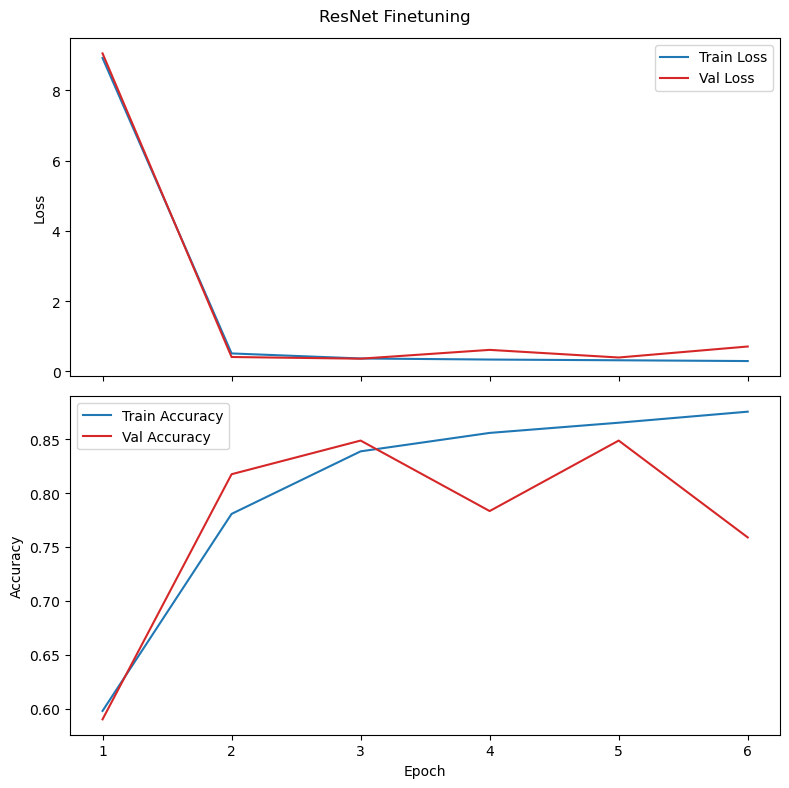

In [19]:
# Plot ResNet training history

import matplotlib.pyplot as plt

def plot_training_history(train_stats, val_stats, title):

  epochs = range(1, len(train_stats) + 1)
  train_losses = [entry[0] for entry in train_stats]
  train_accuracies = [entry[1] for entry in train_stats]
  val_losses = [entry[0] for entry in val_stats]
  val_accuracies = [entry[1] for entry in val_stats]

  fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 8))

  fig.suptitle(title)

  train_colour = 'tab:blue'
  val_colour = 'tab:red'
  # Plotting loss
  ax1.plot(epochs, train_losses, label='Train Loss', color=train_colour)
  ax1.plot(epochs, val_losses, label='Val Loss', color=val_colour)
  ax1.set_ylabel('Loss')
  ax1.legend()

  # Plot accuracy
  ax2.plot(epochs, train_accuracies, label='Train Accuracy', color=train_colour)
  ax2.plot(epochs, val_accuracies, label='Val Accuracy', color=val_colour)
  ax2.set_xlabel('Epoch')
  ax2.set_ylabel('Accuracy')
  ax2.legend()

  plt.tight_layout()
  return plt.show()

plot_training_history(ResNet_train_stats, ResNet_val_stats, "ResNet Finetuning")

In [ ]:
TUNING LR...

In [6]:
import torch
from torchvision.models import resnet50
import matplotlib.pyplot as plt

def experiment(lr, model_name, model):
    print(f"EXPERIMENT lr={lr} model_name={model_name}")

    # Modify the output layer for multilabel classification with the new number of classes
    
    new_num_classes = 4  # {Clover, Grass, Dung, Soil}
    
    # Define a new class to wrap the model with a sigmoid activation
    class MultiLabelResNet(torch.nn.Module):
        def __init__(self, original_model, num_classes):
            super(MultiLabelResNet, self).__init__()
            self.resnet = original_model
            self.resnet.fc = torch.nn.Linear(in_features=2048, out_features=num_classes)
            self.sigmoid = torch.nn.Sigmoid()
    
        def forward(self, x):
            x = self.resnet(x)
            x = self.sigmoid(x)
            return x
    
    model = MultiLabelResNet(model, new_num_classes)

    def freeze_weights(model):
      # freezes all weights
      for param in model.parameters():
          param.requires_grad = False
    
    def unfreeze_after_layer4(model):
      # unfreezes weights in layer4 & fc
      for name, param in model.named_parameters():
        if 'layer4' in name or 'fc' in name:
          param.requires_grad = True
    
    # freeze all weights
    freeze_weights(model)
    
    # unfreeze final layers for finetuning
    unfreeze_after_layer4(model)

    # Define loss function and optimiser
    loss_function = nn.BCELoss()  # Binary cross-entropy loss for one-hot labels
    optimiser = optim.Adam(model.parameters(), lr=lr)  # Adjust learning rate as needed
    
    # Detect if GPU is available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    # Fine-tune the model
    model, model_train_stats, model_val_stats = fine_tune(model, train_loader, val_loader, optimiser, loss_function, num_epochs=10)
    
    # Save the model
    torch.save(model.state_dict(), f'{model_name}_lr{lr}.pth')

    # Plot training history
    
    def plot_training_history(train_stats, val_stats, title):
    
      epochs = range(1, len(train_stats) + 1)
      train_losses = [entry[0] for entry in train_stats]
      train_accuracies = [entry[1] for entry in train_stats]
      val_losses = [entry[0] for entry in val_stats]
      val_accuracies = [entry[1] for entry in val_stats]
    
      fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 8))
    
      fig.suptitle(title)
    
      train_colour = 'tab:blue'
      val_colour = 'tab:red'
      # Plotting loss
      ax1.plot(epochs, train_losses, label='Train Loss', color=train_colour)
      ax1.plot(epochs, val_losses, label='Val Loss', color=val_colour)
      ax1.set_ylabel('Loss')
      ax1.legend()
    
      # Plot accuracy
      ax2.plot(epochs, train_accuracies, label='Train Accuracy', color=train_colour)
      ax2.plot(epochs, val_accuracies, label='Val Accuracy', color=val_colour)
      ax2.set_xlabel('Epoch')
      ax2.set_ylabel('Accuracy')
      ax2.legend()
    
      plt.tight_layout()
      return plt.show()
    
    plot_training_history(model_train_stats, model_val_stats, f"{model_name} Finetuning lr={lr}")

In [7]:
# experiment with ResNet

# Load target model
def load_model():
  model = resnet50()
  return model

experiment(0.001, "ResNet", load_model())
experiment(0.0001, "ResNet", load_model())
experiment(0.00001, "ResNet", load_model())
experiment(0.000001, "ResNet", load_model())
experiment(0.0000001, "ResNet", load_model())

EXPERIMENT lr=0.001 model_name=ResNet


NameError: name 'optim' is not defined

/home/omsst2/jupyter-env/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/omsst2/jupyter-env/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/omsst2/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 246MB/s]


EXPERIMENT lr=0.001 model_name=Pretrained ResNet


100%|██████████| 19/19 [00:05<00:00,  3.55it/s]


Initial Train loss: 0.72, Train accuracy: 0.46, Val loss: 0.72, Val accuracy: 0.47
epoch 0


100%|██████████| 19/19 [00:05<00:00,  3.49it/s]


Epoch [1/10], Train loss: 0.24, Train accuracy: 0.90, Val loss: 0.22, Val accuracy: 0.91
epoch 1


100%|██████████| 19/19 [00:05<00:00,  3.51it/s]


Epoch [2/10], Train loss: 0.16, Train accuracy: 0.94, Val loss: 0.21, Val accuracy: 0.92
epoch 2


100%|██████████| 19/19 [00:05<00:00,  3.53it/s]


Epoch [3/10], Train loss: 0.12, Train accuracy: 0.96, Val loss: 0.22, Val accuracy: 0.93
epoch 3


100%|██████████| 19/19 [00:06<00:00,  3.02it/s]


Epoch [4/10], Train loss: 0.09, Train accuracy: 0.97, Val loss: 0.28, Val accuracy: 0.92
epoch 4


100%|██████████| 19/19 [00:05<00:00,  3.40it/s]


Epoch [5/10], Train loss: 0.09, Train accuracy: 0.97, Val loss: 0.25, Val accuracy: 0.94
epoch 5


100%|██████████| 19/19 [00:05<00:00,  3.45it/s]


Epoch [6/10], Train loss: 0.06, Train accuracy: 0.98, Val loss: 0.29, Val accuracy: 0.92
epoch 6


100%|██████████| 19/19 [00:05<00:00,  3.38it/s]


Epoch [7/10], Train loss: 0.05, Train accuracy: 0.98, Val loss: 0.25, Val accuracy: 0.93
epoch 7


100%|██████████| 19/19 [00:05<00:00,  3.46it/s]


Epoch [8/10], Train loss: 0.03, Train accuracy: 0.99, Val loss: 0.27, Val accuracy: 0.93
epoch 8


100%|██████████| 19/19 [00:05<00:00,  3.44it/s]


Epoch [9/10], Train loss: 0.02, Train accuracy: 0.99, Val loss: 0.25, Val accuracy: 0.94
epoch 9


100%|██████████| 19/19 [00:05<00:00,  3.33it/s]


Epoch [10/10], Train loss: 0.03, Train accuracy: 0.99, Val loss: 0.31, Val accuracy: 0.93
Fine-tuning complete in 6m 4s


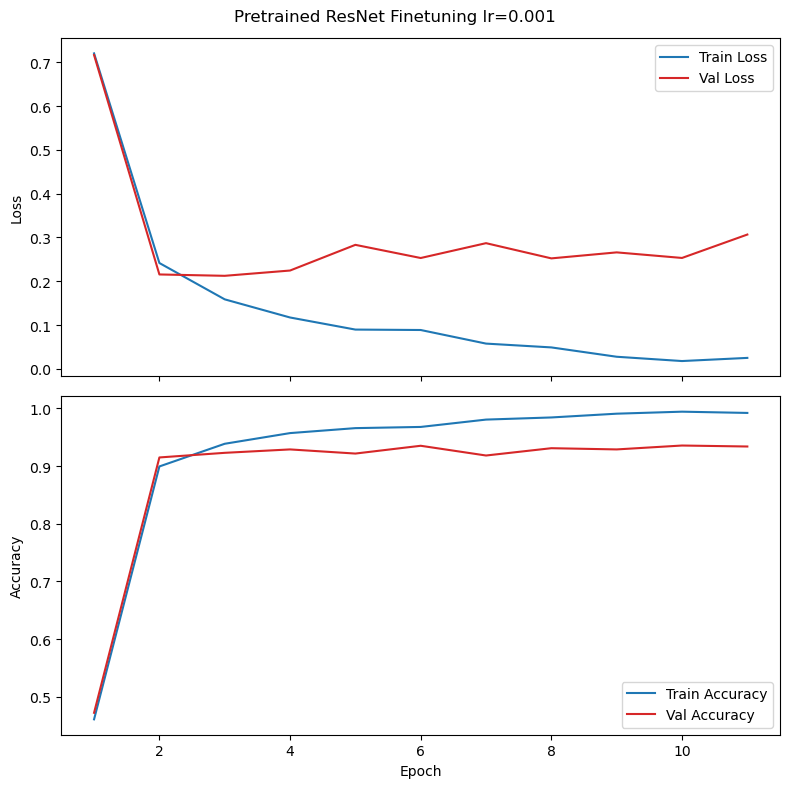

EXPERIMENT lr=0.0001 model_name=Pretrained ResNet


100%|██████████| 19/19 [00:05<00:00,  3.70it/s]


Initial Train loss: 0.69, Train accuracy: 0.49, Val loss: 0.69, Val accuracy: 0.48
epoch 0


100%|██████████| 19/19 [00:05<00:00,  3.55it/s]


Epoch [1/10], Train loss: 0.26, Train accuracy: 0.89, Val loss: 0.22, Val accuracy: 0.92
epoch 1


100%|██████████| 19/19 [00:05<00:00,  3.52it/s]


Epoch [2/10], Train loss: 0.13, Train accuracy: 0.95, Val loss: 0.20, Val accuracy: 0.93
epoch 2


100%|██████████| 19/19 [00:05<00:00,  3.29it/s]


Epoch [3/10], Train loss: 0.08, Train accuracy: 0.97, Val loss: 0.21, Val accuracy: 0.92
epoch 3


100%|██████████| 19/19 [00:05<00:00,  3.37it/s]


Epoch [4/10], Train loss: 0.05, Train accuracy: 0.98, Val loss: 0.20, Val accuracy: 0.93
epoch 4


100%|██████████| 19/19 [00:05<00:00,  3.30it/s]


Epoch [5/10], Train loss: 0.03, Train accuracy: 0.99, Val loss: 0.22, Val accuracy: 0.92
epoch 5


100%|██████████| 19/19 [00:05<00:00,  3.46it/s]


Epoch [6/10], Train loss: 0.02, Train accuracy: 1.00, Val loss: 0.20, Val accuracy: 0.93
epoch 6


100%|██████████| 19/19 [00:05<00:00,  3.52it/s]


Epoch [7/10], Train loss: 0.01, Train accuracy: 1.00, Val loss: 0.23, Val accuracy: 0.93
epoch 7


100%|██████████| 19/19 [00:05<00:00,  3.26it/s]


Epoch [8/10], Train loss: 0.01, Train accuracy: 1.00, Val loss: 0.22, Val accuracy: 0.93
epoch 8


100%|██████████| 19/19 [00:05<00:00,  3.43it/s]


Epoch [9/10], Train loss: 0.01, Train accuracy: 1.00, Val loss: 0.22, Val accuracy: 0.93
epoch 9


100%|██████████| 19/19 [00:05<00:00,  3.37it/s]


Epoch [10/10], Train loss: 0.01, Train accuracy: 1.00, Val loss: 0.23, Val accuracy: 0.94
Fine-tuning complete in 6m 4s


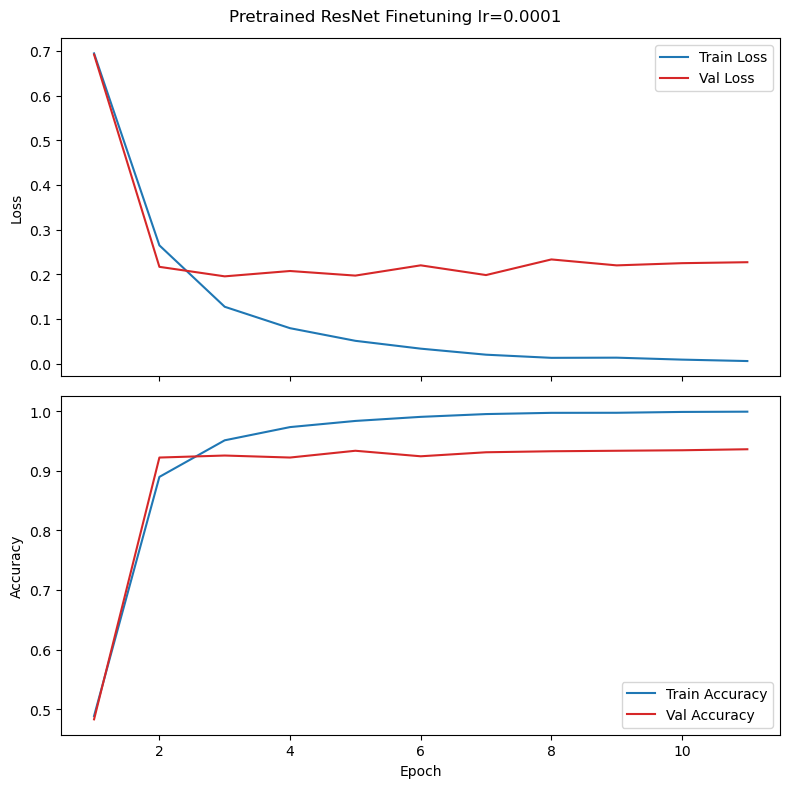

EXPERIMENT lr=1e-05 model_name=Pretrained ResNet


100%|██████████| 19/19 [00:05<00:00,  3.64it/s]


Initial Train loss: 0.74, Train accuracy: 0.43, Val loss: 0.74, Val accuracy: 0.42
epoch 0


100%|██████████| 19/19 [00:05<00:00,  3.45it/s]


Epoch [1/10], Train loss: 0.50, Train accuracy: 0.83, Val loss: 0.35, Val accuracy: 0.89
epoch 1


100%|██████████| 19/19 [00:05<00:00,  3.55it/s]


Epoch [2/10], Train loss: 0.30, Train accuracy: 0.90, Val loss: 0.26, Val accuracy: 0.91
epoch 2


100%|██████████| 19/19 [00:05<00:00,  3.57it/s]


Epoch [3/10], Train loss: 0.23, Train accuracy: 0.92, Val loss: 0.22, Val accuracy: 0.92
epoch 3


100%|██████████| 19/19 [00:05<00:00,  3.49it/s]


Epoch [4/10], Train loss: 0.20, Train accuracy: 0.93, Val loss: 0.21, Val accuracy: 0.92
epoch 4


100%|██████████| 19/19 [00:05<00:00,  3.38it/s]


Epoch [5/10], Train loss: 0.16, Train accuracy: 0.94, Val loss: 0.20, Val accuracy: 0.92
epoch 5


100%|██████████| 19/19 [00:05<00:00,  3.65it/s]


Epoch [6/10], Train loss: 0.14, Train accuracy: 0.95, Val loss: 0.20, Val accuracy: 0.93
epoch 6


100%|██████████| 19/19 [00:05<00:00,  3.50it/s]


Epoch [7/10], Train loss: 0.13, Train accuracy: 0.96, Val loss: 0.20, Val accuracy: 0.93
epoch 7


100%|██████████| 19/19 [00:05<00:00,  3.61it/s]


Epoch [8/10], Train loss: 0.11, Train accuracy: 0.97, Val loss: 0.20, Val accuracy: 0.93
epoch 8


100%|██████████| 19/19 [00:05<00:00,  3.42it/s]


Epoch [9/10], Train loss: 0.09, Train accuracy: 0.97, Val loss: 0.19, Val accuracy: 0.93
epoch 9


100%|██████████| 19/19 [00:05<00:00,  3.49it/s]


Epoch [10/10], Train loss: 0.08, Train accuracy: 0.98, Val loss: 0.20, Val accuracy: 0.93
Fine-tuning complete in 6m 2s


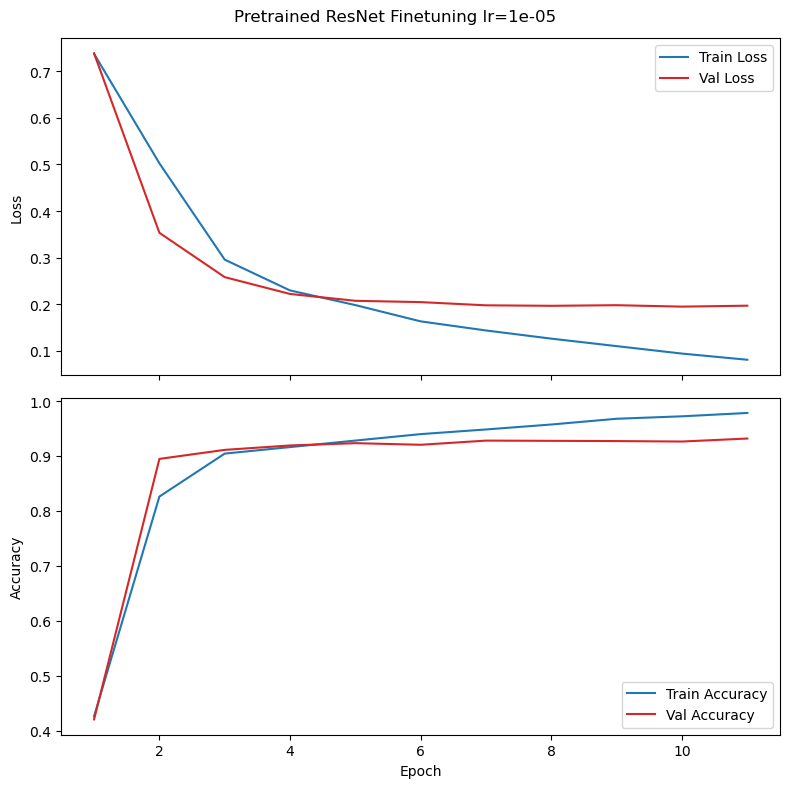

EXPERIMENT lr=1e-06 model_name=Pretrained ResNet


100%|██████████| 19/19 [00:05<00:00,  3.69it/s]


Initial Train loss: 0.67, Train accuracy: 0.59, Val loss: 0.67, Val accuracy: 0.58
epoch 0


100%|██████████| 19/19 [00:05<00:00,  3.26it/s]


Epoch [1/10], Train loss: 0.65, Train accuracy: 0.68, Val loss: 0.62, Val accuracy: 0.71
epoch 1


100%|██████████| 19/19 [00:05<00:00,  3.38it/s]


Epoch [2/10], Train loss: 0.60, Train accuracy: 0.77, Val loss: 0.57, Val accuracy: 0.79
epoch 2


100%|██████████| 19/19 [00:05<00:00,  3.50it/s]


Epoch [3/10], Train loss: 0.55, Train accuracy: 0.83, Val loss: 0.53, Val accuracy: 0.84
epoch 3


100%|██████████| 19/19 [00:05<00:00,  3.36it/s]


Epoch [4/10], Train loss: 0.52, Train accuracy: 0.85, Val loss: 0.50, Val accuracy: 0.86
epoch 4


100%|██████████| 19/19 [00:05<00:00,  3.36it/s]


Epoch [5/10], Train loss: 0.48, Train accuracy: 0.87, Val loss: 0.46, Val accuracy: 0.87
epoch 5


100%|██████████| 19/19 [00:05<00:00,  3.44it/s]


Epoch [6/10], Train loss: 0.45, Train accuracy: 0.88, Val loss: 0.43, Val accuracy: 0.88
epoch 6


100%|██████████| 19/19 [00:05<00:00,  3.24it/s]


Epoch [7/10], Train loss: 0.42, Train accuracy: 0.89, Val loss: 0.41, Val accuracy: 0.89
epoch 7


100%|██████████| 19/19 [00:05<00:00,  3.38it/s]


Epoch [8/10], Train loss: 0.40, Train accuracy: 0.89, Val loss: 0.38, Val accuracy: 0.89
epoch 8


100%|██████████| 19/19 [00:05<00:00,  3.45it/s]


Epoch [9/10], Train loss: 0.37, Train accuracy: 0.90, Val loss: 0.36, Val accuracy: 0.90
epoch 9


100%|██████████| 19/19 [00:05<00:00,  3.49it/s]


Epoch [10/10], Train loss: 0.36, Train accuracy: 0.90, Val loss: 0.35, Val accuracy: 0.90
Fine-tuning complete in 6m 7s


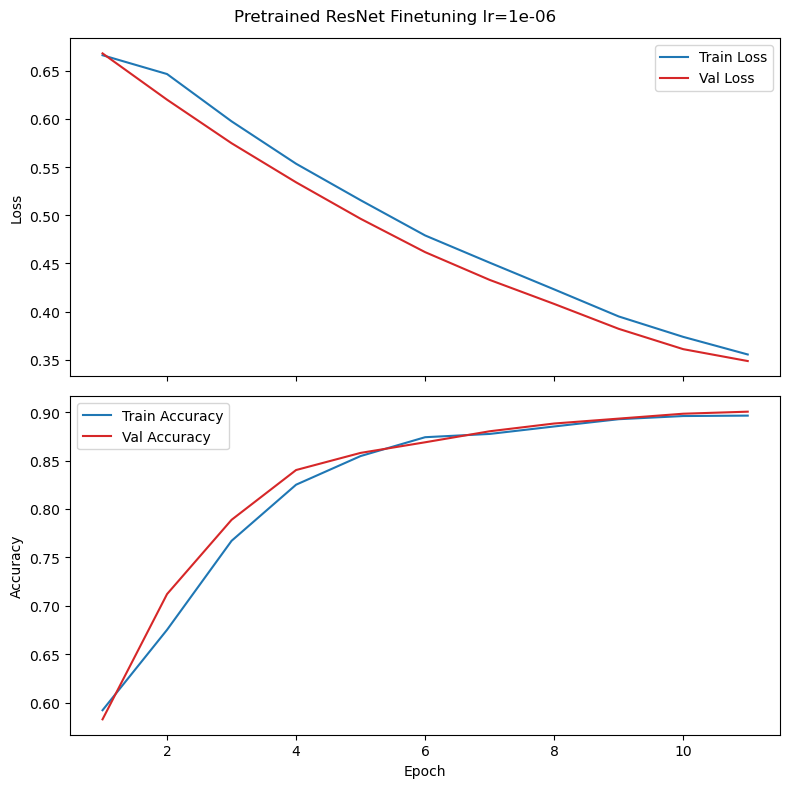

EXPERIMENT lr=1e-07 model_name=Pretrained ResNet


100%|██████████| 19/19 [00:05<00:00,  3.66it/s]


Initial Train loss: 0.73, Train accuracy: 0.38, Val loss: 0.73, Val accuracy: 0.37
epoch 0


100%|██████████| 19/19 [00:05<00:00,  3.30it/s]


Epoch [1/10], Train loss: 0.72, Train accuracy: 0.49, Val loss: 0.73, Val accuracy: 0.49
epoch 1


100%|██████████| 19/19 [00:05<00:00,  3.47it/s]


Epoch [2/10], Train loss: 0.72, Train accuracy: 0.50, Val loss: 0.72, Val accuracy: 0.50
epoch 2


100%|██████████| 19/19 [00:05<00:00,  3.46it/s]


Epoch [3/10], Train loss: 0.71, Train accuracy: 0.51, Val loss: 0.71, Val accuracy: 0.51
epoch 3


100%|██████████| 19/19 [00:05<00:00,  3.52it/s]


Epoch [4/10], Train loss: 0.71, Train accuracy: 0.52, Val loss: 0.71, Val accuracy: 0.52
epoch 4


100%|██████████| 19/19 [00:06<00:00,  3.13it/s]


Epoch [5/10], Train loss: 0.70, Train accuracy: 0.52, Val loss: 0.70, Val accuracy: 0.52
epoch 5


100%|██████████| 19/19 [00:05<00:00,  3.37it/s]


Epoch [6/10], Train loss: 0.70, Train accuracy: 0.53, Val loss: 0.70, Val accuracy: 0.53
epoch 6


100%|██████████| 19/19 [00:05<00:00,  3.57it/s]


Epoch [7/10], Train loss: 0.69, Train accuracy: 0.54, Val loss: 0.69, Val accuracy: 0.54
epoch 7


100%|██████████| 19/19 [00:05<00:00,  3.46it/s]


Epoch [8/10], Train loss: 0.69, Train accuracy: 0.55, Val loss: 0.69, Val accuracy: 0.55
epoch 8


100%|██████████| 19/19 [00:05<00:00,  3.37it/s]


Epoch [9/10], Train loss: 0.68, Train accuracy: 0.56, Val loss: 0.68, Val accuracy: 0.55
epoch 9


100%|██████████| 19/19 [00:05<00:00,  3.46it/s]


Epoch [10/10], Train loss: 0.68, Train accuracy: 0.57, Val loss: 0.68, Val accuracy: 0.56
Fine-tuning complete in 6m 5s


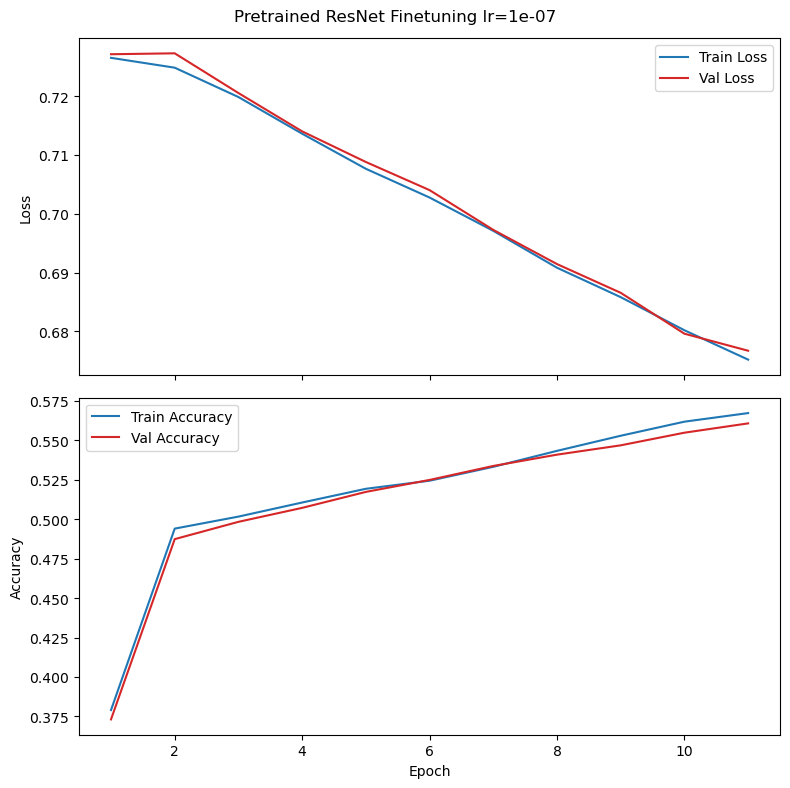

In [29]:
# experiment with ResNet

# Load target model
def load_model():
  model = resnet50(pretrained=True)
  return model

experiment(0.001, "Pretrained ResNet", load_model())
experiment(0.0001, "Pretrained ResNet", load_model())
experiment(0.00001, "Pretrained ResNet", load_model())
experiment(0.000001, "Pretrained ResNet", load_model())
experiment(0.0000001, "Pretrained ResNet", load_model())

In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import inception_v3
import matplotlib.pyplot as plt

def experiment(lr, model_name, model):
    print(f"EXPERIMENT lr={lr} model_name={model_name}")

    new_num_classes = 4  # {Clover, Grass, Dung, Soil}
    
    # Define a new class to wrap the model with a sigmoid activation
    class MultiLabelInceptionV3(nn.Module):
        def __init__(self, original_model, num_classes):
            super(MultiLabelInceptionV3, self).__init__()
            self.inception = original_model
            self.inception.fc = nn.Linear(in_features=2048, out_features=num_classes)
            self.sigmoid = nn.Sigmoid()
    
        def forward(self, x):
            if self.training:
                x, aux = self.inception(x)
                x = self.sigmoid(x)
                aux = self.sigmoid(aux)
                return x, aux
            else:
                x = self.inception(x)
                x = self.sigmoid(x)
                return x
    
    model = MultiLabelInceptionV3(model, new_num_classes)

    def freeze_weights(model):
        # Freeze all weights
        for param in model.parameters():
            param.requires_grad = False
    
    def unfreeze_after_mixed7(model):
        # Unfreeze weights in mixed7 & fc
        for name, param in model.named_parameters():
            if 'Mixed_7' in name or 'fc' in name:
                param.requires_grad = True
    
    # Freeze all weights
    freeze_weights(model)
    
    # Unfreeze final layers for finetuning
    unfreeze_after_mixed7(model)

    # Define loss function and optimizer
    loss_function = nn.BCELoss()  # Binary cross-entropy loss for one-hot labels
    optimizer = optim.Adam(model.parameters(), lr=lr)  # Adjust learning rate as needed
    
    # Detect if GPU is available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    # Fine-tune the model
    model, train_stats, val_stats = fine_tune(
        model, train_loader, val_loader, optimizer, loss_function, num_epochs=10
    )
    
    # Save the model
    torch.save(model.state_dict(), f'{model_name}_lr{lr}.pth')

    # Plot training history
    def plot_training_history(train_stats, val_stats, title):
        epochs = range(1, len(train_stats) + 1)
        train_losses = [entry[0] for entry in train_stats]
        train_accuracies = [entry[1] for entry in train_stats]
        val_losses = [entry[0] for entry in val_stats]
        val_accuracies = [entry[1] for entry in val_stats]
    
        fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 8))
    
        fig.suptitle(title)
    
        train_colour = 'tab:blue'
        val_colour = 'tab:red'
        # Plotting loss
        ax1.plot(epochs, train_losses, label='Train Loss', color=train_colour)
        ax1.plot(epochs, val_losses, label='Val Loss', color=val_colour)
        ax1.set_ylabel('Loss')
        ax1.legend()
    
        # Plot accuracy
        ax2.plot(epochs, train_accuracies, label='Train Accuracy', color=train_colour)
        ax2.plot(epochs, val_accuracies, label='Val Accuracy', color=val_colour)
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.legend()
    
        plt.tight_layout()
        return plt.show()
    
    plot_training_history(train_stats, val_stats, f"{model_name} Finetuning lr={lr}")

# Experiment with InceptionV3

# Load target model
def load_model():
    model = inception_v3(pretrained=True, aux_logits=True)  # InceptionV3 requires aux_logits=True for training
    return model

experiment(0.001, "Pretrained InceptionV3", load_model())
experiment(0.0001, "Pretrained InceptionV3", load_model())
experiment(0.00001, "Pretrained InceptionV3", load_model())
experiment(0.000001, "Pretrained InceptionV3", load_model())
experiment(0.0000001, "Pretrained InceptionV3", load_model())

EXPERIMENT lr=0.001 model_name=Pretrained InceptionV3


100%|██████████| 19/19 [00:07<00:00,  2.42it/s]


Initial Train loss: 0.75, Train accuracy: 0.33, Val loss: 0.76, Val accuracy: 0.34
epoch 0


  0%|          | 0/72 [00:00<?, ?it/s]


AttributeError: 'tuple' object has no attribute 'size'

EXPERIMENT lr=0.001


/tmp/ipykernel_3626201/2394539015.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(weights_file_path, map_location=torch.device('cpu'))
100%|████

Initial Train loss: 0.72, Train accuracy: 0.45, Val loss: 0.71, Val accuracy: 0.46
epoch 0


100%|██████████| 19/19 [00:05<00:00,  3.25it/s]


Epoch [1/10], Train loss: 0.24, Train accuracy: 0.90, Val loss: 0.20, Val accuracy: 0.93
epoch 1


100%|██████████| 19/19 [00:06<00:00,  3.04it/s]


Epoch [2/10], Train loss: 0.15, Train accuracy: 0.94, Val loss: 0.18, Val accuracy: 0.93
epoch 2


100%|██████████| 19/19 [00:05<00:00,  3.43it/s]


Epoch [3/10], Train loss: 0.10, Train accuracy: 0.97, Val loss: 0.22, Val accuracy: 0.92
epoch 3


100%|██████████| 19/19 [00:05<00:00,  3.26it/s]


Epoch [4/10], Train loss: 0.07, Train accuracy: 0.98, Val loss: 0.20, Val accuracy: 0.93
epoch 4


100%|██████████| 19/19 [00:05<00:00,  3.39it/s]


Epoch [5/10], Train loss: 0.05, Train accuracy: 0.98, Val loss: 0.32, Val accuracy: 0.93
epoch 5


100%|██████████| 19/19 [00:06<00:00,  3.02it/s]


Epoch [6/10], Train loss: 0.03, Train accuracy: 0.99, Val loss: 0.22, Val accuracy: 0.94
epoch 6


100%|██████████| 19/19 [00:05<00:00,  3.37it/s]


Epoch [7/10], Train loss: 0.02, Train accuracy: 0.99, Val loss: 0.24, Val accuracy: 0.93
epoch 7


100%|██████████| 19/19 [00:05<00:00,  3.55it/s]


Epoch [8/10], Train loss: 0.02, Train accuracy: 0.99, Val loss: 0.28, Val accuracy: 0.94
epoch 8


100%|██████████| 19/19 [00:05<00:00,  3.54it/s]


Epoch [9/10], Train loss: 0.01, Train accuracy: 1.00, Val loss: 0.27, Val accuracy: 0.94
epoch 9


100%|██████████| 19/19 [00:06<00:00,  3.05it/s]


Epoch [10/10], Train loss: 0.01, Train accuracy: 1.00, Val loss: 0.36, Val accuracy: 0.94
Fine-tuning complete in 6m 14s


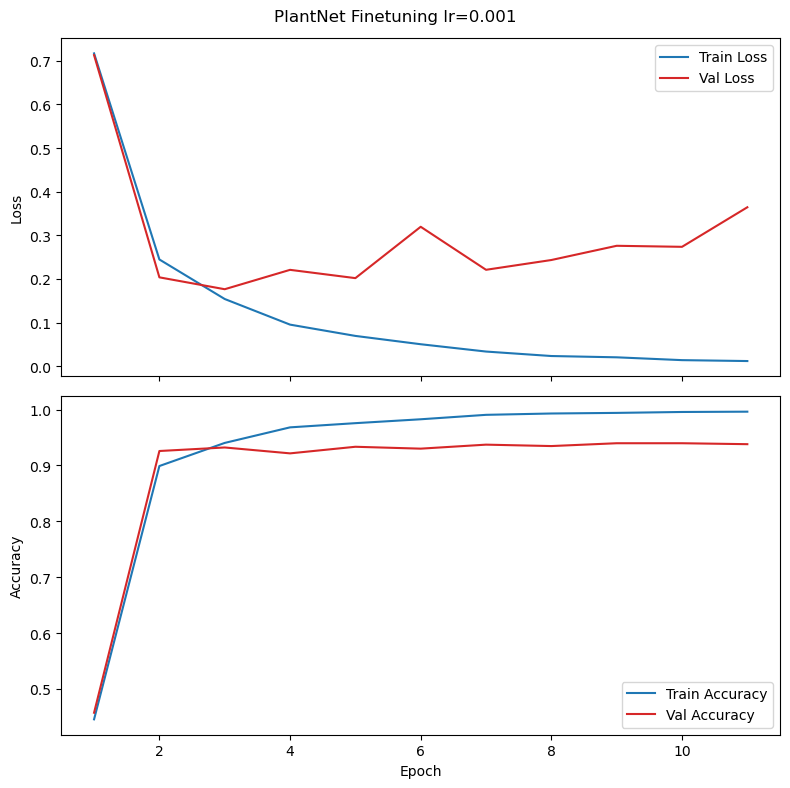

EXPERIMENT lr=0.0001


100%|██████████| 19/19 [00:05<00:00,  3.38it/s]


Initial Train loss: 0.66, Train accuracy: 0.64, Val loss: 0.66, Val accuracy: 0.65
epoch 0


100%|██████████| 19/19 [00:05<00:00,  3.21it/s]


Epoch [1/10], Train loss: 0.30, Train accuracy: 0.89, Val loss: 0.19, Val accuracy: 0.93
epoch 1


100%|██████████| 19/19 [00:05<00:00,  3.37it/s]


Epoch [2/10], Train loss: 0.16, Train accuracy: 0.94, Val loss: 0.17, Val accuracy: 0.94
epoch 2


100%|██████████| 19/19 [00:05<00:00,  3.47it/s]


Epoch [3/10], Train loss: 0.10, Train accuracy: 0.96, Val loss: 0.16, Val accuracy: 0.94
epoch 3


100%|██████████| 19/19 [00:06<00:00,  2.97it/s]


Epoch [4/10], Train loss: 0.08, Train accuracy: 0.97, Val loss: 0.17, Val accuracy: 0.94
epoch 4


100%|██████████| 19/19 [00:05<00:00,  3.44it/s]


Epoch [5/10], Train loss: 0.05, Train accuracy: 0.99, Val loss: 0.19, Val accuracy: 0.93
epoch 5


100%|██████████| 19/19 [00:05<00:00,  3.38it/s]


Epoch [6/10], Train loss: 0.03, Train accuracy: 0.99, Val loss: 0.18, Val accuracy: 0.94
epoch 6


100%|██████████| 19/19 [00:06<00:00,  3.01it/s]


Epoch [7/10], Train loss: 0.03, Train accuracy: 0.99, Val loss: 0.20, Val accuracy: 0.93
epoch 7


100%|██████████| 19/19 [00:05<00:00,  3.26it/s]


Epoch [8/10], Train loss: 0.02, Train accuracy: 1.00, Val loss: 0.19, Val accuracy: 0.94
epoch 8


100%|██████████| 19/19 [00:05<00:00,  3.48it/s]


Epoch [9/10], Train loss: 0.01, Train accuracy: 1.00, Val loss: 0.19, Val accuracy: 0.94
epoch 9


100%|██████████| 19/19 [00:06<00:00,  3.14it/s]


Epoch [10/10], Train loss: 0.02, Train accuracy: 1.00, Val loss: 0.22, Val accuracy: 0.93
Fine-tuning complete in 6m 11s


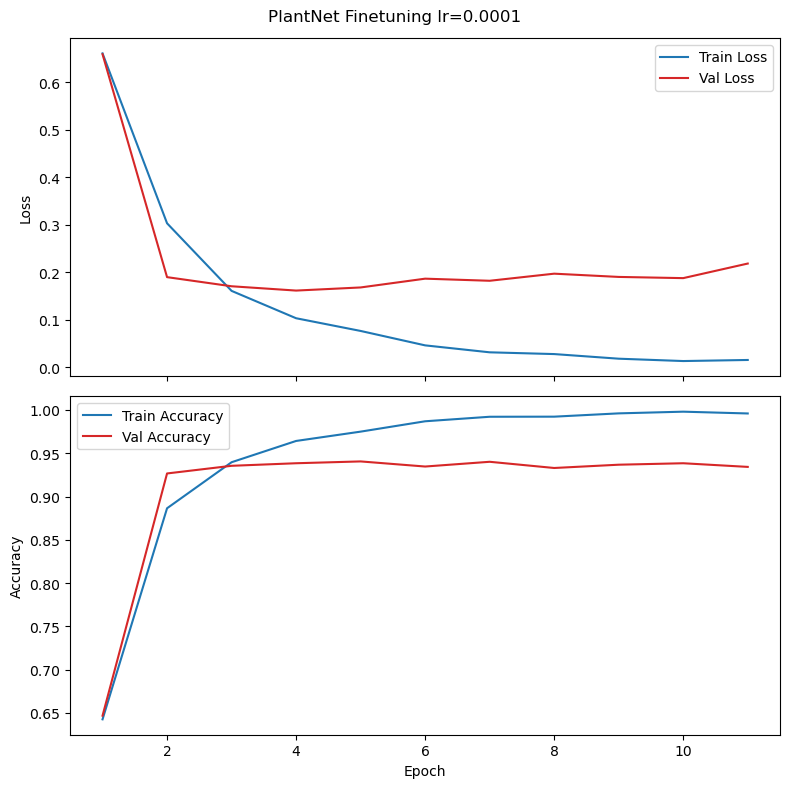

EXPERIMENT lr=1e-05


100%|██████████| 19/19 [00:05<00:00,  3.68it/s]


Initial Train loss: 0.70, Train accuracy: 0.52, Val loss: 0.71, Val accuracy: 0.51
epoch 0


100%|██████████| 19/19 [00:05<00:00,  3.68it/s]


Epoch [1/10], Train loss: 0.59, Train accuracy: 0.76, Val loss: 0.50, Val accuracy: 0.87
epoch 1


100%|██████████| 19/19 [00:05<00:00,  3.65it/s]


Epoch [2/10], Train loss: 0.43, Train accuracy: 0.89, Val loss: 0.36, Val accuracy: 0.91
epoch 2


100%|██████████| 19/19 [00:05<00:00,  3.62it/s]


Epoch [3/10], Train loss: 0.32, Train accuracy: 0.91, Val loss: 0.28, Val accuracy: 0.92
epoch 3


100%|██████████| 19/19 [00:05<00:00,  3.58it/s]


Epoch [4/10], Train loss: 0.26, Train accuracy: 0.91, Val loss: 0.24, Val accuracy: 0.92
epoch 4


100%|██████████| 19/19 [00:05<00:00,  3.72it/s]


Epoch [5/10], Train loss: 0.23, Train accuracy: 0.92, Val loss: 0.22, Val accuracy: 0.92
epoch 5


100%|██████████| 19/19 [00:05<00:00,  3.68it/s]


Epoch [6/10], Train loss: 0.20, Train accuracy: 0.93, Val loss: 0.21, Val accuracy: 0.93
epoch 6


100%|██████████| 19/19 [00:05<00:00,  3.64it/s]


Epoch [7/10], Train loss: 0.19, Train accuracy: 0.93, Val loss: 0.20, Val accuracy: 0.93
epoch 7


100%|██████████| 19/19 [00:05<00:00,  3.64it/s]


Epoch [8/10], Train loss: 0.17, Train accuracy: 0.94, Val loss: 0.19, Val accuracy: 0.93
epoch 8


100%|██████████| 19/19 [00:05<00:00,  3.64it/s]


Epoch [9/10], Train loss: 0.16, Train accuracy: 0.94, Val loss: 0.19, Val accuracy: 0.93
epoch 9


100%|██████████| 19/19 [00:05<00:00,  3.67it/s]


Epoch [10/10], Train loss: 0.15, Train accuracy: 0.95, Val loss: 0.18, Val accuracy: 0.93
Fine-tuning complete in 5m 51s


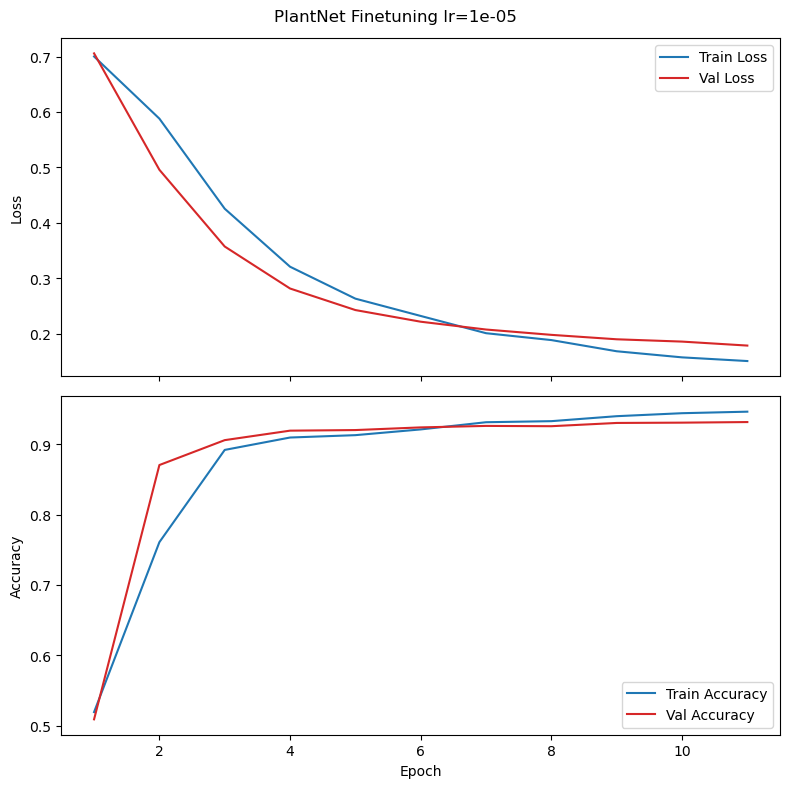

EXPERIMENT lr=1e-06


100%|██████████| 19/19 [00:04<00:00,  3.87it/s]


Initial Train loss: 0.68, Train accuracy: 0.60, Val loss: 0.68, Val accuracy: 0.60
epoch 0


100%|██████████| 19/19 [00:04<00:00,  3.84it/s]


Epoch [1/10], Train loss: 0.68, Train accuracy: 0.54, Val loss: 0.67, Val accuracy: 0.58
epoch 1


100%|██████████| 19/19 [00:04<00:00,  3.80it/s]


Epoch [2/10], Train loss: 0.66, Train accuracy: 0.63, Val loss: 0.65, Val accuracy: 0.66
epoch 2


100%|██████████| 19/19 [00:04<00:00,  3.82it/s]


Epoch [3/10], Train loss: 0.64, Train accuracy: 0.70, Val loss: 0.63, Val accuracy: 0.72
epoch 3


100%|██████████| 19/19 [00:04<00:00,  3.87it/s]


Epoch [4/10], Train loss: 0.62, Train accuracy: 0.75, Val loss: 0.61, Val accuracy: 0.77
epoch 4


100%|██████████| 19/19 [00:04<00:00,  3.82it/s]


Epoch [5/10], Train loss: 0.60, Train accuracy: 0.80, Val loss: 0.59, Val accuracy: 0.82
epoch 5


100%|██████████| 19/19 [00:04<00:00,  3.84it/s]


Epoch [6/10], Train loss: 0.58, Train accuracy: 0.82, Val loss: 0.57, Val accuracy: 0.84
epoch 6


100%|██████████| 19/19 [00:04<00:00,  3.84it/s]


Epoch [7/10], Train loss: 0.56, Train accuracy: 0.84, Val loss: 0.55, Val accuracy: 0.86
epoch 7


100%|██████████| 19/19 [00:04<00:00,  3.85it/s]


Epoch [8/10], Train loss: 0.54, Train accuracy: 0.86, Val loss: 0.54, Val accuracy: 0.87
epoch 8


100%|██████████| 19/19 [00:05<00:00,  3.79it/s]


Epoch [9/10], Train loss: 0.53, Train accuracy: 0.86, Val loss: 0.52, Val accuracy: 0.87
epoch 9


100%|██████████| 19/19 [00:04<00:00,  3.86it/s]


Epoch [10/10], Train loss: 0.51, Train accuracy: 0.87, Val loss: 0.50, Val accuracy: 0.88
Fine-tuning complete in 5m 37s


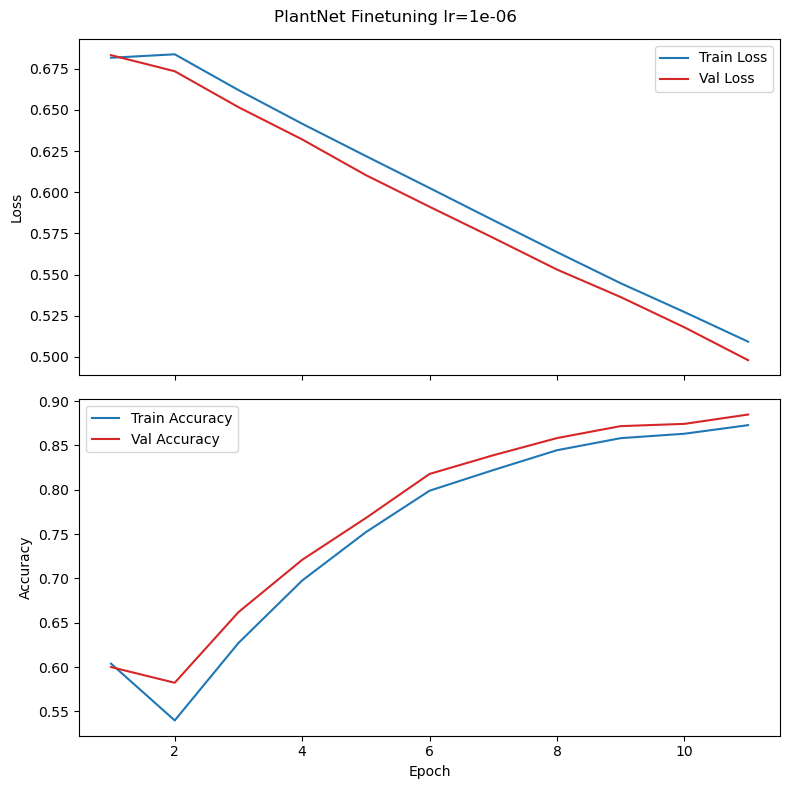

EXPERIMENT lr=1e-07


100%|██████████| 19/19 [00:04<00:00,  3.89it/s]


Initial Train loss: 0.69, Train accuracy: 0.50, Val loss: 0.70, Val accuracy: 0.49
epoch 0


100%|██████████| 19/19 [00:04<00:00,  3.85it/s]


Epoch [1/10], Train loss: 0.70, Train accuracy: 0.48, Val loss: 0.70, Val accuracy: 0.48
epoch 1


100%|██████████| 19/19 [00:05<00:00,  3.76it/s]


Epoch [2/10], Train loss: 0.70, Train accuracy: 0.49, Val loss: 0.70, Val accuracy: 0.49
epoch 2


100%|██████████| 19/19 [00:05<00:00,  3.76it/s]


Epoch [3/10], Train loss: 0.69, Train accuracy: 0.49, Val loss: 0.70, Val accuracy: 0.50
epoch 3


100%|██████████| 19/19 [00:05<00:00,  3.68it/s]


Epoch [4/10], Train loss: 0.69, Train accuracy: 0.51, Val loss: 0.69, Val accuracy: 0.51
epoch 4


100%|██████████| 19/19 [00:05<00:00,  3.59it/s]


Epoch [5/10], Train loss: 0.69, Train accuracy: 0.52, Val loss: 0.69, Val accuracy: 0.52
epoch 5


100%|██████████| 19/19 [00:05<00:00,  3.69it/s]


Epoch [6/10], Train loss: 0.69, Train accuracy: 0.53, Val loss: 0.69, Val accuracy: 0.53
epoch 6


100%|██████████| 19/19 [00:04<00:00,  3.85it/s]


Epoch [7/10], Train loss: 0.68, Train accuracy: 0.54, Val loss: 0.69, Val accuracy: 0.53
epoch 7


100%|██████████| 19/19 [00:04<00:00,  3.90it/s]


Epoch [8/10], Train loss: 0.68, Train accuracy: 0.56, Val loss: 0.68, Val accuracy: 0.55
epoch 8


100%|██████████| 19/19 [00:05<00:00,  3.68it/s]


Epoch [9/10], Train loss: 0.68, Train accuracy: 0.57, Val loss: 0.68, Val accuracy: 0.56
epoch 9


100%|██████████| 19/19 [00:04<00:00,  3.86it/s]


Epoch [10/10], Train loss: 0.68, Train accuracy: 0.58, Val loss: 0.68, Val accuracy: 0.57
Fine-tuning complete in 5m 42s


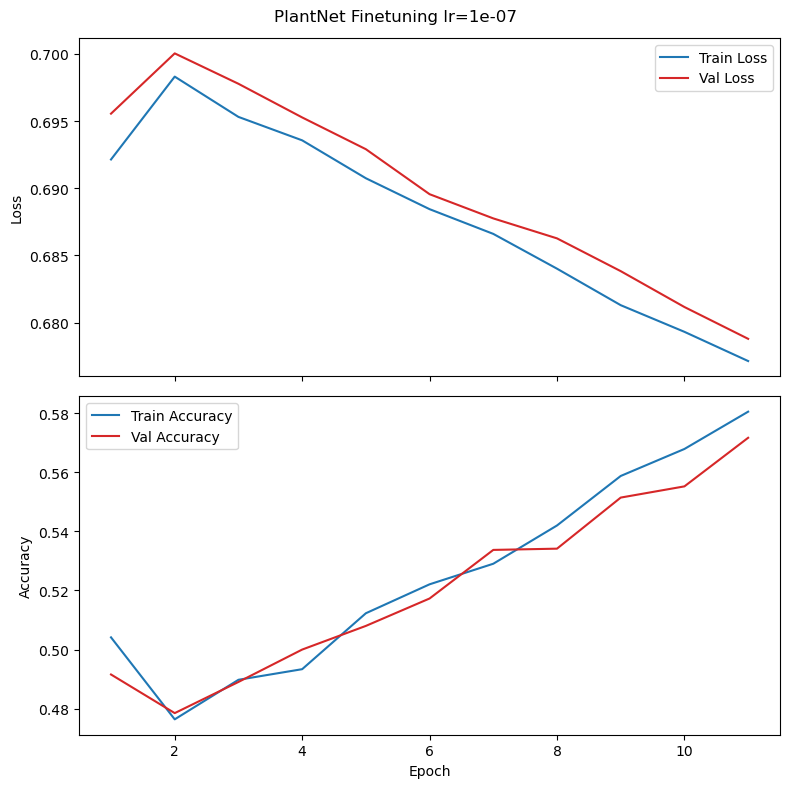

In [79]:
# experiment_plantnet(0.01)
experiment_plantnet(0.001)
experiment_plantnet(0.0001)
experiment_plantnet(0.00001)
experiment_plantnet(0.000001)
experiment_plantnet(0.0000001)

In [ ]:
#@title Inception V3

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import inception_v3
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import keras

def experiment(lr, model_name, model):
    print(f"EXPERIMENT lr={lr} model_name={model_name}")

    new_num_classes = 4  # {Clover, Grass, Dung, Soil}
    
    # Define a new class to wrap the model with a sigmoid activation
    class MultiLabelInceptionV3(nn.Module):
        def __init__(self, original_model, num_classes):
            super(MultiLabelInceptionV3, self).__init__()
            self.inception = original_model
            self.inception.fc = nn.Linear(in_features=2048, out_features=num_classes)
            self.inception.AuxLogits.fc = nn.Linear(in_features=768, out_features=num_classes)
            self.sigmoid = nn.Sigmoid()
    
        def forward(self, x):
            if self.training and self.inception.aux_logits:
                x, aux = self.inception(x)
                x = self.sigmoid(x)
                aux = self.sigmoid(aux)
                return x, aux
            else:
                x = self.inception(x)
                x = self.sigmoid(x)
                return x
    
    model = MultiLabelInceptionV3(model, new_num_classes)

    def freeze_weights(model):
        # Freeze all weights
        for param in model.parameters():
            param.requires_grad = False
    
    def unfreeze_after_mixed7(model):
        # Unfreeze weights in mixed7 & fc
        for name, param in model.named_parameters():
            if 'Mixed_7' in name or 'fc' in name:
                param.requires_grad = True
    
    # Freeze all weights
    freeze_weights(model)
    
    # Unfreeze final layers for finetuning
    unfreeze_after_mixed7(model)

    # Define loss function and optimizer
    loss_function = nn.BCELoss()  # Binary cross-entropy loss for one-hot labels
    optimizer = optim.Adam(model.parameters(), lr=lr)  # Adjust learning rate as needed
    
    # Detect if GPU is available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    # Fine-tuning function
    def fine_tune(model, train_loader, val_loader, optimizer, loss_function, num_epochs=10):

        ''' Inspired by https://keras.io/guides/writing_a_custom_training_loop_in_torch/ '''

        start = time.time()

        # Use keras function for computing accuracy
        # NB labels are one-hot encoded
        # NBB BinaryAccuracy rather than Categorical (less harsh)
        train_acc_metric = keras.metrics.BinaryAccuracy()
        val_acc_metric = keras.metrics.BinaryAccuracy()

        # lists to store loss/accuracy tuples of each epoch
        epoch_train_stats = []
        epoch_val_stats = []

        # Initial evaluation before fine-tuning
        def evaluate_model(model, data_loader, loss_function, acc_metric):
            model.eval()
            running_loss = 0.0
            num_batches = 0
            with torch.no_grad():
                for inputs, targets in tqdm(data_loader, desc="Evaluating", leave=False):
                    inputs = inputs.to(device)
                    targets = targets.to(device)

                    logits = model(inputs)
                    if isinstance(logits, tuple):
                        logits, _ = logits
                    loss = loss_function(logits, targets)

                    acc_metric.update_state(targets.cpu().detach().numpy(), logits.cpu().detach().numpy())

                    running_loss += loss.item()
                    num_batches += 1

            epoch_loss = running_loss / num_batches
            epoch_acc = acc_metric.result().numpy()
            acc_metric.reset_state()

            return epoch_loss, epoch_acc

        # Evaluate model on training and validation datasets before training
        initial_train_loss, initial_train_acc = evaluate_model(model, train_loader, loss_function, train_acc_metric)
        epoch_train_stats.append((initial_train_loss, initial_train_acc))
        
        initial_val_loss, initial_val_acc = evaluate_model(model, val_loader, loss_function, val_acc_metric)
        epoch_val_stats.append((initial_val_loss, initial_val_acc))

        print(f'Initial Train loss: {initial_train_loss:.2f}, Train accuracy: {initial_train_acc:.2f}, '
              f'Val loss: {initial_val_loss:.2f}, Val accuracy: {initial_val_acc:.2f}')

        for epoch in range(num_epochs):

            print(f"epoch {epoch+1}/{num_epochs}")

            # Set model to training mode
            model.train()

            running_loss = 0.0
            num_batches = 0

            for inputs, targets in tqdm(train_loader, desc="Training", leave=False):

                inputs = inputs.to(device)  # Assuming 'device' is properly set
                targets = targets.to(device)

                optimizer.zero_grad()

                # Forward pass
                logits = model(inputs)
                if isinstance(logits, tuple):
                    logits, aux_logits = logits
                    loss1 = loss_function(logits, targets)
                    loss2 = loss_function(aux_logits, targets)
                    loss = loss1 + 0.4 * loss2
                else:
                    loss = loss_function(logits, targets)

                # Backward pass
                loss.backward()

                # Optimizer variable updates
                optimizer.step()

                # Update training metric
                train_acc_metric.update_state(targets.cpu().detach().numpy(), logits.cpu().detach().numpy())

                # Increment loss & batch count
                running_loss += loss.item()
                num_batches += 1

            # Get train loss & accuracy for the epoch
            train_epoch_loss = running_loss / num_batches
            train_epoch_acc = train_acc_metric.result().numpy()
            epoch_train_stats.append((train_epoch_loss, train_epoch_acc))

            # Run a validation loop at the end of each epoch
            model.eval()
            val_running_loss = 0.0
            val_num_batches = 0

            with torch.no_grad():
                for inputs, targets in tqdm(val_loader, desc="Validating", leave=False):
                    inputs = inputs.to(device)
                    targets = targets.to(device)

                    # Forward pass
                    logits = model(inputs)
                    if isinstance(logits, tuple):
                        logits, _ = logits
                    loss = loss_function(logits, targets)

                    # Update validation metrics
                    val_acc_metric.update_state(targets.cpu().detach().numpy(), logits.cpu().detach().numpy())

                    # Increment validation loss & batch count
                    val_running_loss += loss.item()
                    val_num_batches += 1

            # Get val loss & accuracy for the epoch
            val_epoch_loss = val_running_loss / val_num_batches
            val_epoch_acc = val_acc_metric.result().numpy()
            epoch_val_stats.append((val_epoch_loss, val_epoch_acc))

            # Reset metrics at the end of each epoch
            train_acc_metric.reset_state()
            val_acc_metric.reset_state()

            print(f'Epoch [{epoch + 1}/{num_epochs}], Train loss: {train_epoch_loss:.2f}, Train accuracy: {train_epoch_acc:.2f}, Val loss: {val_epoch_loss:.2f}, Val accuracy: {val_epoch_acc:.2f}')


        elapsed_time = time.time() - start
        print('Fine-tuning complete in {:.0f}m {:.0f}s'.format(elapsed_time // 60, elapsed_time % 60))

        return model, epoch_train_stats, epoch_val_stats
    
    model, train_stats, val_stats = fine_tune(
        model, train_loader, val_loader, optimizer, loss_function, num_epochs=10
    )
    
    # Save the model
    torch.save(model.state_dict(), f'{model_name}_lr{lr}.pth')

    # Plot training history
    def plot_training_history(train_stats, val_stats, title):
    
      epochs = range(1, len(train_stats) + 1)
      train_losses = [entry[0] for entry in train_stats]
      train_accuracies = [entry[1] for entry in train_stats]
      val_losses = [entry[0] for entry in val_stats]
      val_accuracies = [entry[1] for entry in val_stats]
    
      fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 8))
    
      fig.suptitle(title)
    
      train_colour = 'tab:blue'
      val_colour = 'tab:red'
      # Plotting loss
      ax1.plot(epochs, train_losses, label='Train Loss', color=train_colour)
      ax1.plot(epochs, val_losses, label='Val Loss', color=val_colour)
      ax1.set_ylabel('Loss')
      ax1.legend()
    
      # Plot accuracy
      ax2.plot(epochs, train_accuracies, label='Train Accuracy', color=train_colour)
      ax2.plot(epochs, val_accuracies, label='Val Accuracy', color=val_colour)
      ax2.set_xlabel('Epoch')
      ax2.set_ylabel('Accuracy')
      ax2.legend()
    
      plt.tight_layout()
      return plt.show()


    
    plot_training_history(train_stats, val_stats, f"{model_name} Finetuning lr={lr}")

# Experiment with InceptionV3

# Load target model
def load_model():
    model = inception_v3(pretrained=True, aux_logits=True)  # InceptionV3 requires aux_logits=True for training
    return model

experiment(0.001, "Pretrained InceptionV3", load_model())
experiment(0.0001, "Pretrained InceptionV3", load_model())
experiment(0.00001, "Pretrained InceptionV3", load_model())
experiment(0.000001, "Pretrained InceptionV3", load_model())
experiment(0.0000001, "Pretrained InceptionV3", load_model())


EXPERIMENT lr=0.001 model_name=Pretrained InceptionV3


Initial Train loss: 0.75, Train accuracy: 0.33, Val loss: 0.76, Val accuracy: 0.33
epoch 1/10


Epoch [1/10], Train loss: 0.42, Train accuracy: 0.89, Val loss: 0.22, Val accuracy: 0.91
epoch 2/10


Training:   3%|▎         | 2/72 [00:01<00:41,  1.71it/s]

/home/omsst2/jupyter-env/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /home/omsst2/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:00<00:00, 301MB/s] 


EXPERIMENT lr=0.001 model_name=Pretrained AlexNet


Initial Train loss: 0.70, Train accuracy: 0.55, Val loss: 0.70, Val accuracy: 0.55
epoch 1/10


Epoch [1/10], Train loss: 0.32, Train accuracy: 0.87, Val loss: 0.25, Val accuracy: 0.91
epoch 2/10


Epoch [2/10], Train loss: 0.24, Train accuracy: 0.90, Val loss: 0.23, Val accuracy: 0.91
epoch 3/10


Epoch [3/10], Train loss: 0.23, Train accuracy: 0.91, Val loss: 0.22, Val accuracy: 0.91
epoch 4/10


Epoch [4/10], Train loss: 0.22, Train accuracy: 0.91, Val loss: 0.23, Val accuracy: 0.91
epoch 5/10


Epoch [5/10], Train loss: 0.21, Train accuracy: 0.91, Val loss: 0.21, Val accuracy: 0.92
epoch 6/10


Epoch [6/10], Train loss: 0.21, Train accuracy: 0.92, Val loss: 0.22, Val accuracy: 0.92
epoch 7/10


Epoch [7/10], Train loss: 0.20, Train accuracy: 0.92, Val loss: 0.21, Val accuracy: 0.92
epoch 8/10


Epoch [8/10], Train loss: 0.20, Train accuracy: 0.92, Val loss: 0.21, Val accuracy: 0.92
epoch 9/10


Epoch [9/10], Train loss: 0.19, Train accuracy: 0.92, Val loss: 0.20, Val accuracy: 0.92
epoch 10/10


Epoch [10/10], Train loss: 0.19, Train accuracy: 0.92, Val loss: 0.20, Val accuracy: 0.92
Fine-tuning complete in 2m 14s


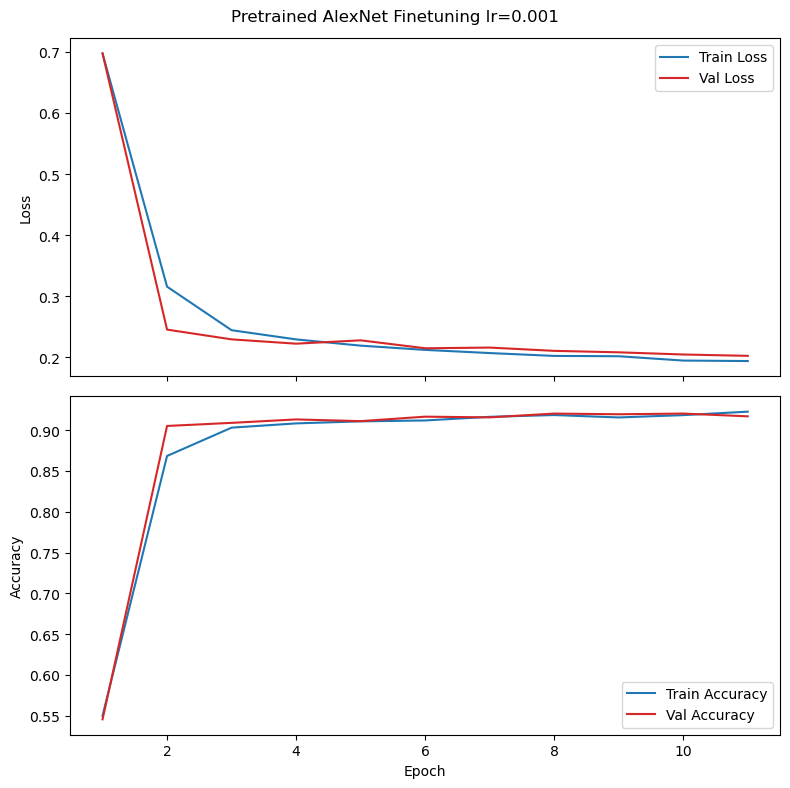

EXPERIMENT lr=0.0001 model_name=Pretrained AlexNet


Initial Train loss: 0.72, Train accuracy: 0.46, Val loss: 0.72, Val accuracy: 0.46
epoch 1/10


Epoch [1/10], Train loss: 0.53, Train accuracy: 0.76, Val loss: 0.42, Val accuracy: 0.85
epoch 2/10


Epoch [2/10], Train loss: 0.38, Train accuracy: 0.87, Val loss: 0.34, Val accuracy: 0.88
epoch 3/10


Epoch [3/10], Train loss: 0.33, Train accuracy: 0.88, Val loss: 0.31, Val accuracy: 0.89
epoch 4/10


Epoch [4/10], Train loss: 0.30, Train accuracy: 0.89, Val loss: 0.29, Val accuracy: 0.89
epoch 5/10


Epoch [5/10], Train loss: 0.29, Train accuracy: 0.89, Val loss: 0.28, Val accuracy: 0.90
epoch 6/10


Epoch [6/10], Train loss: 0.28, Train accuracy: 0.89, Val loss: 0.27, Val accuracy: 0.90
epoch 7/10


Epoch [7/10], Train loss: 0.27, Train accuracy: 0.90, Val loss: 0.26, Val accuracy: 0.90
epoch 8/10


Epoch [8/10], Train loss: 0.26, Train accuracy: 0.90, Val loss: 0.25, Val accuracy: 0.90
epoch 9/10


Epoch [9/10], Train loss: 0.26, Train accuracy: 0.90, Val loss: 0.25, Val accuracy: 0.91
epoch 10/10


Epoch [10/10], Train loss: 0.25, Train accuracy: 0.90, Val loss: 0.25, Val accuracy: 0.91
Fine-tuning complete in 2m 15s


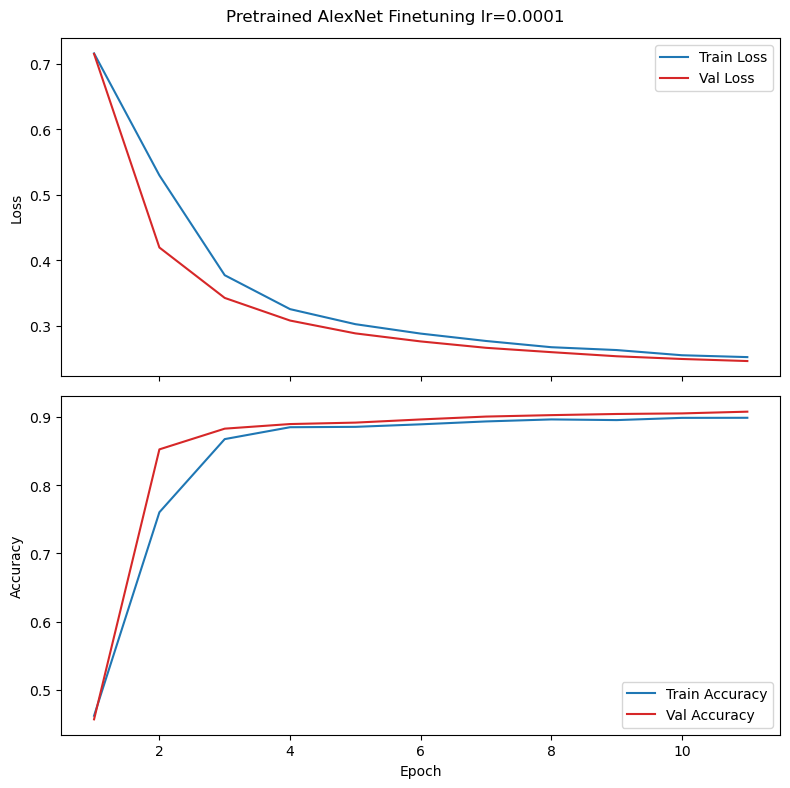

EXPERIMENT lr=1e-05 model_name=Pretrained AlexNet


Initial Train loss: 0.72, Train accuracy: 0.43, Val loss: 0.72, Val accuracy: 0.45
epoch 1/10


Epoch [1/10], Train loss: 0.69, Train accuracy: 0.53, Val loss: 0.66, Val accuracy: 0.62
epoch 2/10


Epoch [2/10], Train loss: 0.64, Train accuracy: 0.66, Val loss: 0.62, Val accuracy: 0.71
epoch 3/10


Epoch [3/10], Train loss: 0.60, Train accuracy: 0.73, Val loss: 0.58, Val accuracy: 0.74
epoch 4/10


Epoch [4/10], Train loss: 0.56, Train accuracy: 0.75, Val loss: 0.55, Val accuracy: 0.76
epoch 5/10


Epoch [5/10], Train loss: 0.53, Train accuracy: 0.77, Val loss: 0.52, Val accuracy: 0.78
epoch 6/10


Epoch [6/10], Train loss: 0.51, Train accuracy: 0.79, Val loss: 0.50, Val accuracy: 0.80
epoch 7/10


Epoch [7/10], Train loss: 0.49, Train accuracy: 0.81, Val loss: 0.48, Val accuracy: 0.82
epoch 8/10


Epoch [8/10], Train loss: 0.47, Train accuracy: 0.82, Val loss: 0.47, Val accuracy: 0.83
epoch 9/10


Epoch [9/10], Train loss: 0.45, Train accuracy: 0.84, Val loss: 0.45, Val accuracy: 0.84
epoch 10/10


Epoch [10/10], Train loss: 0.44, Train accuracy: 0.84, Val loss: 0.44, Val accuracy: 0.85
Fine-tuning complete in 2m 12s


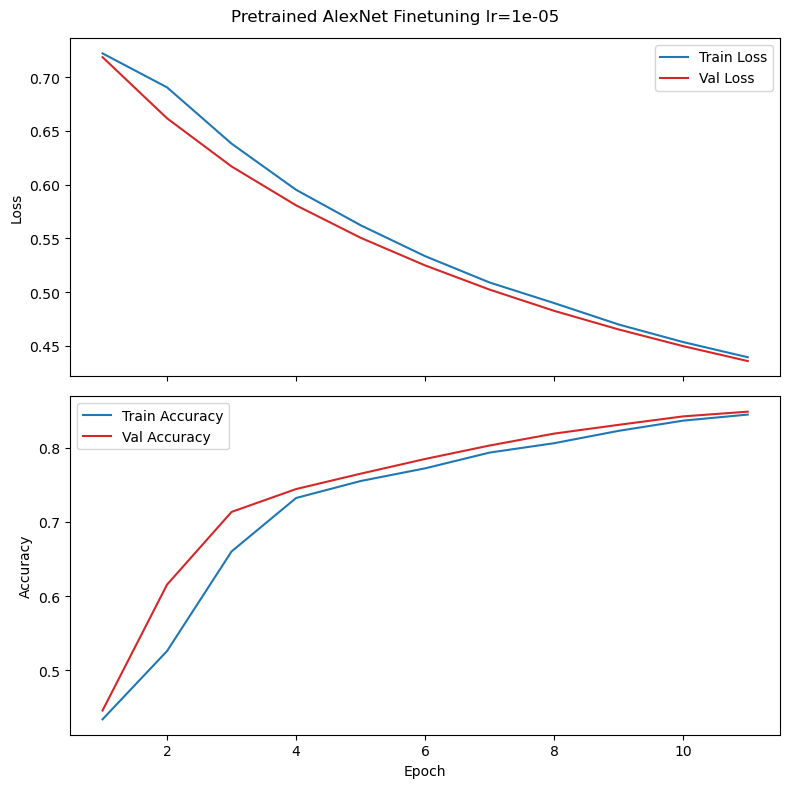

EXPERIMENT lr=1e-06 model_name=Pretrained AlexNet


Initial Train loss: 0.74, Train accuracy: 0.39, Val loss: 0.74, Val accuracy: 0.39
epoch 1/10


Epoch [1/10], Train loss: 0.74, Train accuracy: 0.41, Val loss: 0.74, Val accuracy: 0.41
epoch 2/10


Epoch [2/10], Train loss: 0.73, Train accuracy: 0.42, Val loss: 0.73, Val accuracy: 0.43
epoch 3/10


Epoch [3/10], Train loss: 0.73, Train accuracy: 0.44, Val loss: 0.72, Val accuracy: 0.45
epoch 4/10


Epoch [4/10], Train loss: 0.72, Train accuracy: 0.46, Val loss: 0.72, Val accuracy: 0.47
epoch 5/10


Epoch [5/10], Train loss: 0.71, Train accuracy: 0.47, Val loss: 0.71, Val accuracy: 0.49
epoch 6/10


Epoch [6/10], Train loss: 0.71, Train accuracy: 0.50, Val loss: 0.71, Val accuracy: 0.51
epoch 7/10


Epoch [7/10], Train loss: 0.70, Train accuracy: 0.52, Val loss: 0.70, Val accuracy: 0.53
epoch 8/10


Epoch [8/10], Train loss: 0.70, Train accuracy: 0.53, Val loss: 0.70, Val accuracy: 0.54
epoch 9/10


Epoch [9/10], Train loss: 0.69, Train accuracy: 0.55, Val loss: 0.69, Val accuracy: 0.56
epoch 10/10


Epoch [10/10], Train loss: 0.69, Train accuracy: 0.57, Val loss: 0.68, Val accuracy: 0.57
Fine-tuning complete in 2m 10s


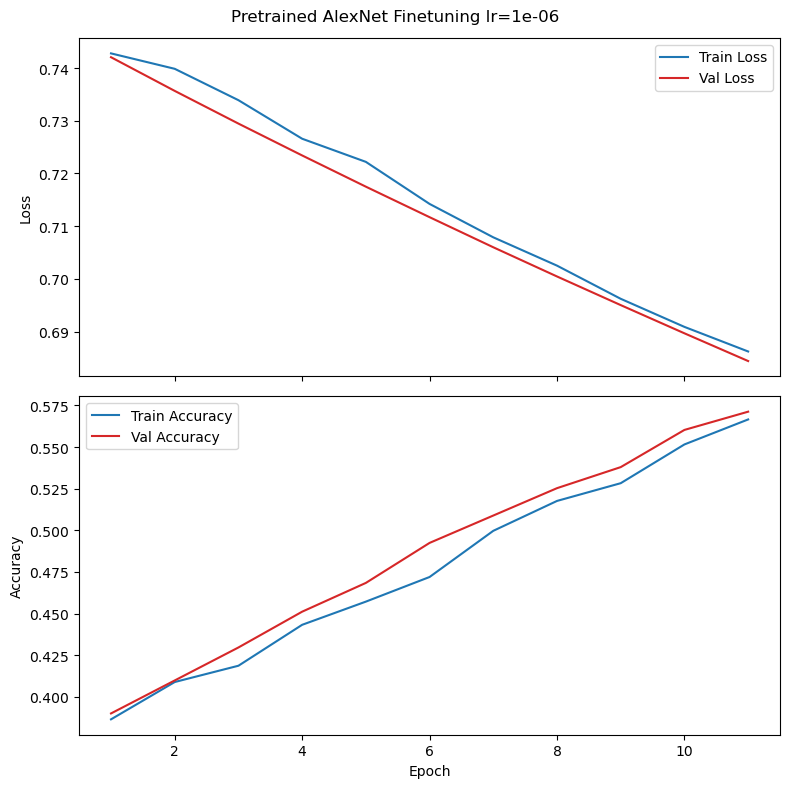

EXPERIMENT lr=1e-07 model_name=Pretrained AlexNet


Initial Train loss: 0.69, Train accuracy: 0.51, Val loss: 0.69, Val accuracy: 0.51
epoch 1/10


Epoch [1/10], Train loss: 0.69, Train accuracy: 0.52, Val loss: 0.69, Val accuracy: 0.51
epoch 2/10


Epoch [2/10], Train loss: 0.69, Train accuracy: 0.52, Val loss: 0.69, Val accuracy: 0.52
epoch 3/10


Epoch [3/10], Train loss: 0.69, Train accuracy: 0.53, Val loss: 0.69, Val accuracy: 0.52
epoch 4/10


Epoch [4/10], Train loss: 0.69, Train accuracy: 0.53, Val loss: 0.69, Val accuracy: 0.52
epoch 5/10


Epoch [5/10], Train loss: 0.69, Train accuracy: 0.52, Val loss: 0.69, Val accuracy: 0.52
epoch 6/10


Epoch [6/10], Train loss: 0.69, Train accuracy: 0.53, Val loss: 0.69, Val accuracy: 0.53
epoch 7/10


Epoch [7/10], Train loss: 0.69, Train accuracy: 0.54, Val loss: 0.69, Val accuracy: 0.53
epoch 8/10


Epoch [8/10], Train loss: 0.69, Train accuracy: 0.54, Val loss: 0.69, Val accuracy: 0.53
epoch 9/10


Epoch [9/10], Train loss: 0.69, Train accuracy: 0.54, Val loss: 0.69, Val accuracy: 0.53
epoch 10/10


Epoch [10/10], Train loss: 0.69, Train accuracy: 0.55, Val loss: 0.69, Val accuracy: 0.53
Fine-tuning complete in 2m 10s


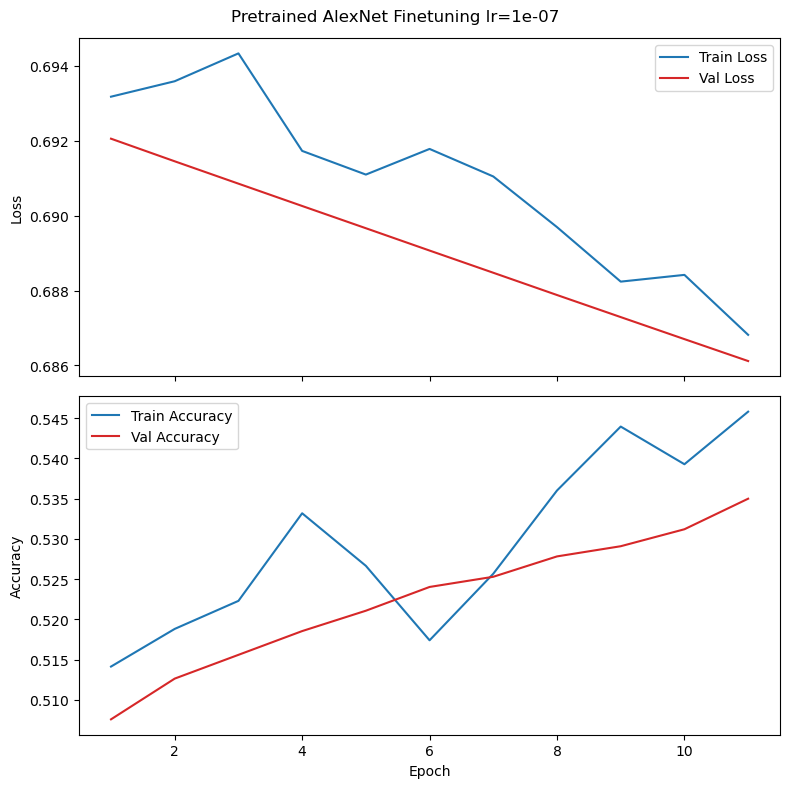

In [41]:
#@title AlexNet

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import alexnet
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import keras

def experiment(lr, model_name, model):
    print(f"EXPERIMENT lr={lr} model_name={model_name}")

    new_num_classes = 4  # {Clover, Grass, Dung, Soil}
    
    # Define a new class to wrap the model with a sigmoid activation
    class MultiLabelAlexNet(nn.Module):
        def __init__(self, original_model, num_classes):
            super(MultiLabelAlexNet, self).__init__()
            self.alexnet = original_model
            self.alexnet.classifier[6] = nn.Linear(in_features=4096, out_features=num_classes)
            self.sigmoid = nn.Sigmoid()
    
        def forward(self, x):
            x = self.alexnet(x)
            x = self.sigmoid(x)
            return x
    
    model = MultiLabelAlexNet(model, new_num_classes)

    def freeze_weights(model):
        # Freeze all weights
        for param in model.parameters():
            param.requires_grad = False
    
    def unfreeze_last_layers(model):
        # Unfreeze weights in the last layers
        for name, param in model.named_parameters():
            if 'classifier.6' in name:
                param.requires_grad = True
    
    # Freeze all weights
    freeze_weights(model)
    
    # Unfreeze final layers for finetuning
    unfreeze_last_layers(model)

    # Define loss function and optimizer
    loss_function = nn.BCELoss()  # Binary cross-entropy loss for one-hot labels
    optimizer = optim.Adam(model.parameters(), lr=lr)  # Adjust learning rate as needed
    
    # Detect if GPU is available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    # Fine-tuning function
    def fine_tune(model, train_loader, val_loader, optimizer, loss_function, num_epochs=10):

        ''' Inspired by https://keras.io/guides/writing_a_custom_training_loop_in_torch/ '''

        start = time.time()

        # Use keras function for computing accuracy
        # NB labels are one-hot encoded
        # NBB BinaryAccuracy rather than Categorical (less harsh)
        train_acc_metric = keras.metrics.BinaryAccuracy()
        val_acc_metric = keras.metrics.BinaryAccuracy()

        # lists to store loss/accuracy tuples of each epoch
        epoch_train_stats = []
        epoch_val_stats = []

        # Initial evaluation before fine-tuning
        def evaluate_model(model, data_loader, loss_function, acc_metric):
            model.eval()
            running_loss = 0.0
            num_batches = 0
            with torch.no_grad():
                for inputs, targets in tqdm(data_loader, desc="Evaluating", leave=False):
                    inputs = inputs.to(device)
                    targets = targets.to(device)

                    logits = model(inputs)
                    loss = loss_function(logits, targets)

                    acc_metric.update_state(targets.cpu().detach().numpy(), logits.cpu().detach().numpy())

                    running_loss += loss.item()
                    num_batches += 1

            epoch_loss = running_loss / num_batches
            epoch_acc = acc_metric.result().numpy()
            acc_metric.reset_state()

            return epoch_loss, epoch_acc

        # Evaluate model on training and validation datasets before training
        initial_train_loss, initial_train_acc = evaluate_model(model, train_loader, loss_function, train_acc_metric)
        epoch_train_stats.append((initial_train_loss, initial_train_acc))
        
        initial_val_loss, initial_val_acc = evaluate_model(model, val_loader, loss_function, val_acc_metric)
        epoch_val_stats.append((initial_val_loss, initial_val_acc))

        print(f'Initial Train loss: {initial_train_loss:.2f}, Train accuracy: {initial_train_acc:.2f}, '
              f'Val loss: {initial_val_loss:.2f}, Val accuracy: {initial_val_acc:.2f}')

        for epoch in range(num_epochs):

            print(f"epoch {epoch+1}/{num_epochs}")

            # Set model to training mode
            model.train()

            running_loss = 0.0
            num_batches = 0

            for inputs, targets in tqdm(train_loader, desc="Training", leave=False):

                inputs = inputs.to(device)  # Assuming 'device' is properly set
                targets = targets.to(device)

                optimizer.zero_grad()

                # Forward pass
                logits = model(inputs)
                loss = loss_function(logits, targets)

                # Backward pass
                loss.backward()

                # Optimizer variable updates
                optimizer.step()

                # Update training metric
                train_acc_metric.update_state(targets.cpu().detach().numpy(), logits.cpu().detach().numpy())

                # Increment loss & batch count
                running_loss += loss.item()
                num_batches += 1

            # Get train loss & accuracy for the epoch
            train_epoch_loss = running_loss / num_batches
            train_epoch_acc = train_acc_metric.result().numpy()
            epoch_train_stats.append((train_epoch_loss, train_epoch_acc))

            # Run a validation loop at the end of each epoch
            model.eval()
            val_running_loss = 0.0
            val_num_batches = 0

            with torch.no_grad():
                for inputs, targets in tqdm(val_loader, desc="Validating", leave=False):
                    inputs = inputs.to(device)
                    targets = targets.to(device)

                    # Forward pass
                    logits = model(inputs)
                    loss = loss_function(logits, targets)

                    # Update validation metrics
                    val_acc_metric.update_state(targets.cpu().detach().numpy(), logits.cpu().detach().numpy())

                    # Increment validation loss & batch count
                    val_running_loss += loss.item()
                    val_num_batches += 1

            # Get val loss & accuracy for the epoch
            val_epoch_loss = val_running_loss / val_num_batches
            val_epoch_acc = val_acc_metric.result().numpy()
            epoch_val_stats.append((val_epoch_loss, val_epoch_acc))

            # Reset metrics at the end of each epoch
            train_acc_metric.reset_state()
            val_acc_metric.reset_state()

            print(f'Epoch [{epoch + 1}/{num_epochs}], Train loss: {train_epoch_loss:.2f}, Train accuracy: {train_epoch_acc:.2f}, Val loss: {val_epoch_loss:.2f}, Val accuracy: {val_epoch_acc:.2f}')


        elapsed_time = time.time() - start
        print('Fine-tuning complete in {:.0f}m {:.0f}s'.format(elapsed_time // 60, elapsed_time % 60))

        return model, epoch_train_stats, epoch_val_stats
    
    model, train_stats, val_stats = fine_tune(
        model, train_loader, val_loader, optimizer, loss_function, num_epochs=10
    )
    
    # Save the model
    torch.save(model.state_dict(), f'{model_name}_lr{lr}.pth')

    # Plot training history
    def plot_training_history(train_stats, val_stats, title):
    
      epochs = range(1, len(train_stats) + 1)
      train_losses = [entry[0] for entry in train_stats]
      train_accuracies = [entry[1] for entry in train_stats]
      val_losses = [entry[0] for entry in val_stats]
      val_accuracies = [entry[1] for entry in val_stats]
    
      fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 8))
    
      fig.suptitle(title)
    
      train_colour = 'tab:blue'
      val_colour = 'tab:red'
      # Plotting loss
      ax1.plot(epochs, train_losses, label='Train Loss', color=train_colour)
      ax1.plot(epochs, val_losses, label='Val Loss', color=val_colour)
      ax1.set_ylabel('Loss')
      ax1.legend()
    
      # Plot accuracy
      ax2.plot(epochs, train_accuracies, label='Train Accuracy', color=train_colour)
      ax2.plot(epochs, val_accuracies, label='Val Accuracy', color=val_colour)
      ax2.set_xlabel('Epoch')
      ax2.set_ylabel('Accuracy')
      ax2.legend()
    
      plt.tight_layout()
      return plt.show()

    
    plot_training_history(train_stats, val_stats, f"{model_name} Finetuning lr={lr}")

# Experiment with AlexNet

# Load target model
def load_model():
    model = alexnet(pretrained=True)
    return model

experiment(0.001, "Pretrained AlexNet", load_model())
experiment(0.0001, "Pretrained AlexNet", load_model())
experiment(0.00001, "Pretrained AlexNet", load_model())
experiment(0.000001, "Pretrained AlexNet", load_model())
experiment(0.0000001, "Pretrained AlexNet", load_model())


In [42]:
#@title VGG16

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import vgg16
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import keras

def experiment(lr, model_name, model):
    print(f"EXPERIMENT lr={lr} model_name={model_name}")

    new_num_classes = 4  # {Clover, Grass, Dung, Soil}
    
    # Define a new class to wrap the model with a sigmoid activation
    class MultiLabelVGG16(nn.Module):
        def __init__(self, original_model, num_classes):
            super(MultiLabelVGG16, self).__init__()
            self.vgg16 = original_model
            self.vgg16.classifier[6] = nn.Linear(in_features=4096, out_features=num_classes)
            self.sigmoid = nn.Sigmoid()
    
        def forward(self, x):
            x = self.vgg16(x)
            x = self.sigmoid(x)
            return x
    
    model = MultiLabelVGG16(model, new_num_classes)

    def freeze_weights(model):
        # Freeze all weights
        for param in model.parameters():
            param.requires_grad = False
    
    def unfreeze_last_layers(model):
        # Unfreeze weights in the last layers
        for name, param in model.named_parameters():
            if 'classifier.6' in name:
                param.requires_grad = True
    
    # Freeze all weights
    freeze_weights(model)
    
    # Unfreeze final layers for finetuning
    unfreeze_last_layers(model)

    # Define loss function and optimizer
    loss_function = nn.BCELoss()  # Binary cross-entropy loss for one-hot labels
    optimizer = optim.Adam(model.parameters(), lr=lr)  # Adjust learning rate as needed
    
    # Detect if GPU is available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    # Fine-tuning function
    def fine_tune(model, train_loader, val_loader, optimizer, loss_function, num_epochs=10):

        ''' Inspired by https://keras.io/guides/writing_a_custom_training_loop_in_torch/ '''

        start = time.time()

        # Use keras function for computing accuracy
        # NB labels are one-hot encoded
        # NBB BinaryAccuracy rather than Categorical (less harsh)
        train_acc_metric = keras.metrics.BinaryAccuracy()
        val_acc_metric = keras.metrics.BinaryAccuracy()

        # lists to store loss/accuracy tuples of each epoch
        epoch_train_stats = []
        epoch_val_stats = []

        # Initial evaluation before fine-tuning
        def evaluate_model(model, data_loader, loss_function, acc_metric):
            model.eval()
            running_loss = 0.0
            num_batches = 0
            with torch.no_grad():
                for inputs, targets in tqdm(data_loader, desc="Evaluating", leave=False):
                    inputs = inputs.to(device)
                    targets = targets.to(device)

                    logits = model(inputs)
                    loss = loss_function(logits, targets)

                    acc_metric.update_state(targets.cpu().detach().numpy(), logits.cpu().detach().numpy())

                    running_loss += loss.item()
                    num_batches += 1

            epoch_loss = running_loss / num_batches
            epoch_acc = acc_metric.result().numpy()
            acc_metric.reset_state()

            return epoch_loss, epoch_acc

        # Evaluate model on training and validation datasets before training
        initial_train_loss, initial_train_acc = evaluate_model(model, train_loader, loss_function, train_acc_metric)
        epoch_train_stats.append((initial_train_loss, initial_train_acc))
        
        initial_val_loss, initial_val_acc = evaluate_model(model, val_loader, loss_function, val_acc_metric)
        epoch_val_stats.append((initial_val_loss, initial_val_acc))

        print(f'Initial Train loss: {initial_train_loss:.2f}, Train accuracy: {initial_train_acc:.2f}, '
              f'Val loss: {initial_val_loss:.2f}, Val accuracy: {initial_val_acc:.2f}')

        for epoch in range(num_epochs):

            print(f"epoch {epoch+1}/{num_epochs}")

            # Set model to training mode
            model.train()

            running_loss = 0.0
            num_batches = 0

            for inputs, targets in tqdm(train_loader, desc="Training", leave=False):

                inputs = inputs.to(device)  # Assuming 'device' is properly set
                targets = targets.to(device)

                optimizer.zero_grad()

                # Forward pass
                logits = model(inputs)
                loss = loss_function(logits, targets)

                # Backward pass
                loss.backward()

                # Optimizer variable updates
                optimizer.step()

                # Update training metric
                train_acc_metric.update_state(targets.cpu().detach().numpy(), logits.cpu().detach().numpy())

                # Increment loss & batch count
                running_loss += loss.item()
                num_batches += 1

            # Get train loss & accuracy for the epoch
            train_epoch_loss = running_loss / num_batches
            train_epoch_acc = train_acc_metric.result().numpy()
            epoch_train_stats.append((train_epoch_loss, train_epoch_acc))

            # Run a validation loop at the end of each epoch
            model.eval()
            val_running_loss = 0.0
            val_num_batches = 0

            with torch.no_grad():
                for inputs, targets in tqdm(val_loader, desc="Validating", leave=False):
                    inputs = inputs.to(device)
                    targets = targets.to(device)

                    # Forward pass
                    logits = model(inputs)
                    loss = loss_function(logits, targets)

                    # Update validation metrics
                    val_acc_metric.update_state(targets.cpu().detach().numpy(), logits.cpu().detach().numpy())

                    # Increment validation loss & batch count
                    val_running_loss += loss.item()
                    val_num_batches += 1

            # Get val loss & accuracy for the epoch
            val_epoch_loss = val_running_loss / val_num_batches
            val_epoch_acc = val_acc_metric.result().numpy()
            epoch_val_stats.append((val_epoch_loss, val_epoch_acc))

            # Reset metrics at the end of each epoch
            train_acc_metric.reset_state()
            val_acc_metric.reset_state()

            print(f'Epoch [{epoch + 1}/{num_epochs}], Train loss: {train_epoch_loss:.2f}, Train accuracy: {train_epoch_acc:.2f}, Val loss: {val_epoch_loss:.2f}, Val accuracy: {val_epoch_acc:.2f}')


        elapsed_time = time.time() - start
        print('Fine-tuning complete in {:.0f}m {:.0f}s'.format(elapsed_time // 60, elapsed_time % 60))

        return model, epoch_train_stats, epoch_val_stats
    
    model, train_stats, val_stats = fine_tune(
        model, train_loader, val_loader, optimizer, loss_function, num_epochs=10
    )
    
    # Save the model
    torch.save(model.state_dict(), f'{model_name}_lr{lr}.pth')

    # Plot training history
    def plot_training_history(train_stats, val_stats, title):
    
      epochs = range(1, len(train_stats) + 1)
      train_losses = [entry[0] for entry in train_stats]
      train_accuracies = [entry[1] for entry in train_stats]
      val_losses = [entry[0] for entry in val_stats]
      val_accuracies = [entry[1] for entry in val_stats]
    
      fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 8))
    
      fig.suptitle(title)
    
      train_colour = 'tab:blue'
      val_colour = 'tab:red'
      # Plotting loss
      ax1.plot(epochs, train_losses, label='Train Loss', color=train_colour)
      ax1.plot(epochs, val_losses, label='Val Loss', color=val_colour)
      ax1.set_ylabel('Loss')
      ax1.legend()
    
      # Plot accuracy
      ax2.plot(epochs, train_accuracies, label='Train Accuracy', color=train_colour)
      ax2.plot(epochs, val_accuracies, label='Val Accuracy', color=val_colour)
      ax2.set_xlabel('Epoch')
      ax2.set_ylabel('Accuracy')
      ax2.legend()
    
      plt.tight_layout()
      return plt.show()

    
    plot_training_history(train_stats, val_stats, f"{model_name} Finetuning lr={lr}")

# Experiment with VGG16

# Load target model
def load_model():
    model = vgg16(pretrained=True)
    return model

experiment(0.001, "Pretrained VGG16", load_model())
experiment(0.0001, "Pretrained VGG16", load_model())
experiment(0.00001, "Pretrained VGG16", load_model())
experiment(0.000001, "Pretrained VGG16", load_model())
experiment(0.0000001, "Pretrained VGG16", load_model())

/home/omsst2/jupyter-env/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/omsst2/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:01<00:00, 300MB/s] 


EXPERIMENT lr=0.001 model_name=Pretrained VGG16


Initial Train loss: 0.70, Train accuracy: 0.50, Val loss: 0.70, Val accuracy: 0.52
epoch 1/10


Epoch [1/10], Train loss: 0.37, Train accuracy: 0.84, Val loss: 0.28, Val accuracy: 0.90
epoch 2/10


Epoch [2/10], Train loss: 0.27, Train accuracy: 0.89, Val loss: 0.25, Val accuracy: 0.91
epoch 3/10


Epoch [3/10], Train loss: 0.25, Train accuracy: 0.90, Val loss: 0.24, Val accuracy: 0.91
epoch 4/10


KeyboardInterrupt: 

/home/omsst2/jupyter-env/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /home/omsst2/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 235MB/s]


EXPERIMENT lr=0.001 model_name=Pretrained DenseNet121


Initial Train loss: 0.68, Train accuracy: 0.51, Val loss: 0.68, Val accuracy: 0.52
epoch 1/10


Epoch [1/10], Train loss: 0.43, Train accuracy: 0.81, Val loss: 0.32, Val accuracy: 0.87
epoch 2/10


Epoch [2/10], Train loss: 0.30, Train accuracy: 0.89, Val loss: 0.27, Val accuracy: 0.90
epoch 3/10


Epoch [3/10], Train loss: 0.27, Train accuracy: 0.90, Val loss: 0.25, Val accuracy: 0.90
epoch 4/10


Epoch [4/10], Train loss: 0.25, Train accuracy: 0.90, Val loss: 0.24, Val accuracy: 0.90
epoch 5/10


Epoch [5/10], Train loss: 0.23, Train accuracy: 0.91, Val loss: 0.23, Val accuracy: 0.91
epoch 6/10


Epoch [6/10], Train loss: 0.23, Train accuracy: 0.91, Val loss: 0.23, Val accuracy: 0.91
epoch 7/10


Epoch [7/10], Train loss: 0.22, Train accuracy: 0.91, Val loss: 0.22, Val accuracy: 0.91
epoch 8/10


Epoch [8/10], Train loss: 0.22, Train accuracy: 0.92, Val loss: 0.22, Val accuracy: 0.91
epoch 9/10


Epoch [9/10], Train loss: 0.21, Train accuracy: 0.92, Val loss: 0.22, Val accuracy: 0.91
epoch 10/10


Epoch [10/10], Train loss: 0.21, Train accuracy: 0.92, Val loss: 0.22, Val accuracy: 0.91
Fine-tuning complete in 12m 56s


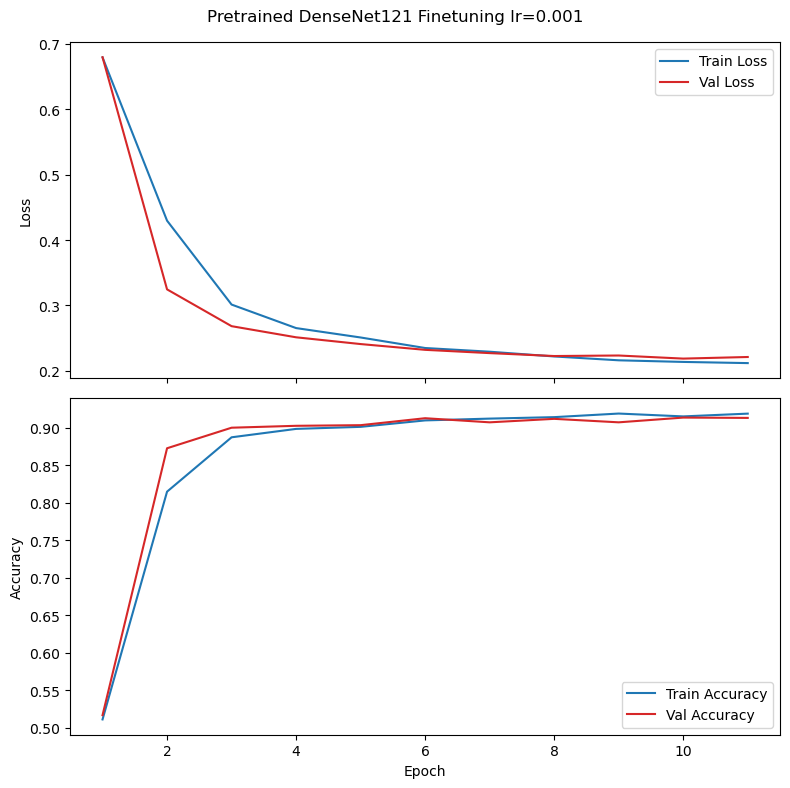

EXPERIMENT lr=0.0001 model_name=Pretrained DenseNet121


Initial Train loss: 0.65, Train accuracy: 0.67, Val loss: 0.65, Val accuracy: 0.67
epoch 1/10


Epoch [1/10], Train loss: 0.63, Train accuracy: 0.65, Val loss: 0.58, Val accuracy: 0.67
epoch 2/10


Epoch [2/10], Train loss: 0.55, Train accuracy: 0.70, Val loss: 0.51, Val accuracy: 0.74
epoch 3/10


Epoch [3/10], Train loss: 0.49, Train accuracy: 0.77, Val loss: 0.46, Val accuracy: 0.81
epoch 4/10


Epoch [4/10], Train loss: 0.45, Train accuracy: 0.82, Val loss: 0.42, Val accuracy: 0.84
epoch 5/10


Epoch [5/10], Train loss: 0.41, Train accuracy: 0.85, Val loss: 0.39, Val accuracy: 0.86
epoch 6/10


Epoch [6/10], Train loss: 0.39, Train accuracy: 0.86, Val loss: 0.37, Val accuracy: 0.87
epoch 7/10


Epoch [7/10], Train loss: 0.37, Train accuracy: 0.87, Val loss: 0.35, Val accuracy: 0.87
epoch 8/10


Epoch [8/10], Train loss: 0.36, Train accuracy: 0.88, Val loss: 0.34, Val accuracy: 0.88
epoch 9/10


Epoch [9/10], Train loss: 0.34, Train accuracy: 0.88, Val loss: 0.33, Val accuracy: 0.88
epoch 10/10


Epoch [10/10], Train loss: 0.33, Train accuracy: 0.88, Val loss: 0.32, Val accuracy: 0.88
Fine-tuning complete in 13m 3s


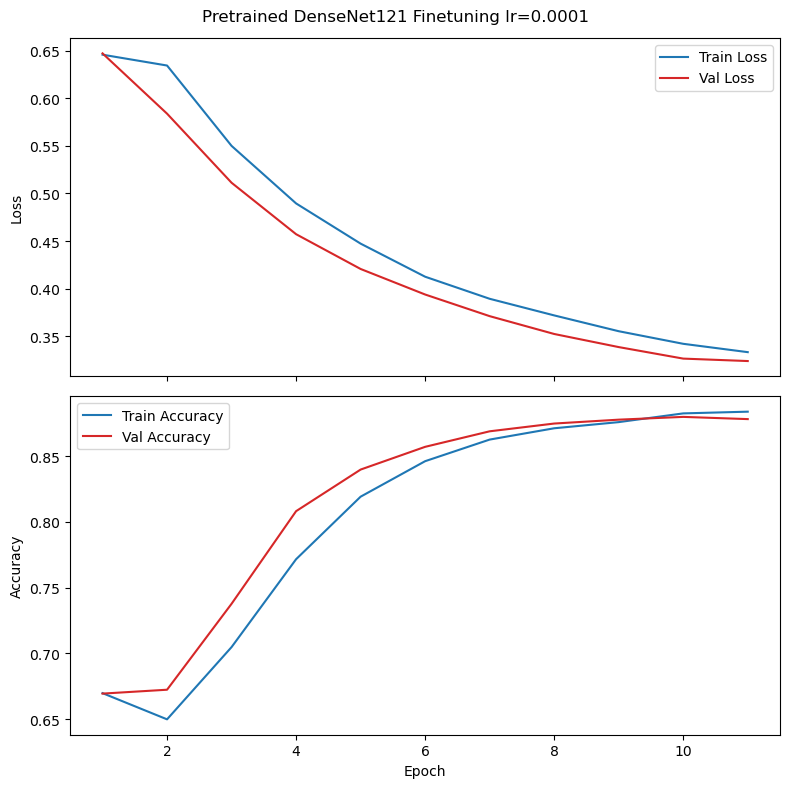

EXPERIMENT lr=1e-05 model_name=Pretrained DenseNet121


Initial Train loss: 0.71, Train accuracy: 0.42, Val loss: 0.71, Val accuracy: 0.42
epoch 1/10


Epoch [1/10], Train loss: 0.68, Train accuracy: 0.56, Val loss: 0.66, Val accuracy: 0.61
epoch 2/10


Epoch [2/10], Train loss: 0.65, Train accuracy: 0.64, Val loss: 0.64, Val accuracy: 0.67
epoch 3/10


KeyboardInterrupt: 

In [43]:
#@title DenseNet

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import densenet121
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import keras

def experiment(lr, model_name, model):
    print(f"EXPERIMENT lr={lr} model_name={model_name}")

    new_num_classes = 4  # {Clover, Grass, Dung, Soil}
    
    # Define a new class to wrap the model with a sigmoid activation
    class MultiLabelDenseNet121(nn.Module):
        def __init__(self, original_model, num_classes):
            super(MultiLabelDenseNet121, self).__init__()
            self.densenet = original_model
            self.densenet.classifier = nn.Linear(in_features=self.densenet.classifier.in_features, out_features=num_classes)
            self.sigmoid = nn.Sigmoid()
    
        def forward(self, x):
            x = self.densenet(x)
            x = self.sigmoid(x)
            return x
    
    model = MultiLabelDenseNet121(model, new_num_classes)

    def freeze_weights(model):
        # Freeze all weights
        for param in model.parameters():
            param.requires_grad = False
    
    def unfreeze_last_layers(model):
        # Unfreeze weights in the last layers
        for name, param in model.named_parameters():
            if 'classifier' in name:
                param.requires_grad = True
    
    # Freeze all weights
    freeze_weights(model)
    
    # Unfreeze final layers for finetuning
    unfreeze_last_layers(model)

    # Define loss function and optimizer
    loss_function = nn.BCELoss()  # Binary cross-entropy loss for one-hot labels
    optimizer = optim.Adam(model.parameters(), lr=lr)  # Adjust learning rate as needed
    
    # Detect if GPU is available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    # Fine-tuning function
    def fine_tune(model, train_loader, val_loader, optimizer, loss_function, num_epochs=10):

        ''' Inspired by https://keras.io/guides/writing_a_custom_training_loop_in_torch/ '''

        start = time.time()

        # Use keras function for computing accuracy
        # NB labels are one-hot encoded
        # NBB BinaryAccuracy rather than Categorical (less harsh)
        train_acc_metric = keras.metrics.BinaryAccuracy()
        val_acc_metric = keras.metrics.BinaryAccuracy()

        # lists to store loss/accuracy tuples of each epoch
        epoch_train_stats = []
        epoch_val_stats = []

        # Initial evaluation before fine-tuning
        def evaluate_model(model, data_loader, loss_function, acc_metric):
            model.eval()
            running_loss = 0.0
            num_batches = 0
            with torch.no_grad():
                for inputs, targets in tqdm(data_loader, desc="Evaluating", leave=False):
                    inputs = inputs.to(device)
                    targets = targets.to(device)

                    logits = model(inputs)
                    loss = loss_function(logits, targets)

                    acc_metric.update_state(targets.cpu().detach().numpy(), logits.cpu().detach().numpy())

                    running_loss += loss.item()
                    num_batches += 1

            epoch_loss = running_loss / num_batches
            epoch_acc = acc_metric.result().numpy()
            acc_metric.reset_state()

            return epoch_loss, epoch_acc

        # Evaluate model on training and validation datasets before training
        initial_train_loss, initial_train_acc = evaluate_model(model, train_loader, loss_function, train_acc_metric)
        epoch_train_stats.append((initial_train_loss, initial_train_acc))
        
        initial_val_loss, initial_val_acc = evaluate_model(model, val_loader, loss_function, val_acc_metric)
        epoch_val_stats.append((initial_val_loss, initial_val_acc))

        print(f'Initial Train loss: {initial_train_loss:.2f}, Train accuracy: {initial_train_acc:.2f}, '
              f'Val loss: {initial_val_loss:.2f}, Val accuracy: {initial_val_acc:.2f}')

        for epoch in range(num_epochs):

            print(f"epoch {epoch+1}/{num_epochs}")

            # Set model to training mode
            model.train()

            running_loss = 0.0
            num_batches = 0

            for inputs, targets in tqdm(train_loader, desc="Training", leave=False):

                inputs = inputs.to(device)  # Assuming 'device' is properly set
                targets = targets.to(device)

                optimizer.zero_grad()

                # Forward pass
                logits = model(inputs)
                loss = loss_function(logits, targets)

                # Backward pass
                loss.backward()

                # Optimizer variable updates
                optimizer.step()

                # Update training metric
                train_acc_metric.update_state(targets.cpu().detach().numpy(), logits.cpu().detach().numpy())

                # Increment loss & batch count
                running_loss += loss.item()
                num_batches += 1

            # Get train loss & accuracy for the epoch
            train_epoch_loss = running_loss / num_batches
            train_epoch_acc = train_acc_metric.result().numpy()
            epoch_train_stats.append((train_epoch_loss, train_epoch_acc))

            # Run a validation loop at the end of each epoch
            model.eval()
            val_running_loss = 0.0
            val_num_batches = 0

            with torch.no_grad():
                for inputs, targets in tqdm(val_loader, desc="Validating", leave=False):
                    inputs = inputs.to(device)
                    targets = targets.to(device)

                    # Forward pass
                    logits = model(inputs)
                    loss = loss_function(logits, targets)

                    # Update validation metrics
                    val_acc_metric.update_state(targets.cpu().detach().numpy(), logits.cpu().detach().numpy())

                    # Increment validation loss & batch count
                    val_running_loss += loss.item()
                    val_num_batches += 1

            # Get val loss & accuracy for the epoch
            val_epoch_loss = val_running_loss / val_num_batches
            val_epoch_acc = val_acc_metric.result().numpy()
            epoch_val_stats.append((val_epoch_loss, val_epoch_acc))

            # Reset metrics at the end of each epoch
            train_acc_metric.reset_state()
            val_acc_metric.reset_state()

            print(f'Epoch [{epoch + 1}/{num_epochs}], Train loss: {train_epoch_loss:.2f}, Train accuracy: {train_epoch_acc:.2f}, Val loss: {val_epoch_loss:.2f}, Val accuracy: {val_epoch_acc:.2f}')


        elapsed_time = time.time() - start
        print('Fine-tuning complete in {:.0f}m {:.0f}s'.format(elapsed_time // 60, elapsed_time % 60))

        return model, epoch_train_stats, epoch_val_stats
    
    model, train_stats, val_stats = fine_tune(
        model, train_loader, val_loader, optimizer, loss_function, num_epochs=10
    )
    
    # Save the model
    torch.save(model.state_dict(), f'{model_name}_lr{lr}.pth')

    # Plot training history
    def plot_training_history(train_stats, val_stats, title):
    
      epochs = range(1, len(train_stats) + 1)
      train_losses = [entry[0] for entry in train_stats]
      train_accuracies = [entry[1] for entry in train_stats]
      val_losses = [entry[0] for entry in val_stats]
      val_accuracies = [entry[1] for entry in val_stats]
    
      fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 8))
    
      fig.suptitle(title)
    
      train_colour = 'tab:blue'
      val_colour = 'tab:red'
      # Plotting loss
      ax1.plot(epochs, train_losses, label='Train Loss', color=train_colour)
      ax1.plot(epochs, val_losses, label='Val Loss', color=val_colour)
      ax1.set_ylabel('Loss')
      ax1.legend()
    
      # Plot accuracy
      ax2.plot(epochs, train_accuracies, label='Train Accuracy', color=train_colour)
      ax2.plot(epochs, val_accuracies, label='Val Accuracy', color=val_colour)
      ax2.set_xlabel('Epoch')
      ax2.set_ylabel('Accuracy')
      ax2.legend()
    
      plt.tight_layout()
      return plt.show()

    
    plot_training_history(train_stats, val_stats, f"{model_name} Finetuning lr={lr}")

# Experiment with DenseNet121

# Load target model
def load_model():
    model = densenet121(pretrained=True)
    return model

experiment(0.001, "Pretrained DenseNet121", load_model())
experiment(0.0001, "Pretrained DenseNet121", load_model())
experiment(0.00001, "Pretrained DenseNet121", load_model())
experiment(0.000001, "Pretrained DenseNet121", load_model())
experiment(0.0000001, "Pretrained DenseNet121", load_model())

In [52]:
# Make true labels array of val set

import numpy as np

true_labels = []
for _, labels in val_dataset:
  true_labels.append(labels.numpy())
true_labels = np.vstack(true_labels)


In [94]:
!pip install tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 4.2 MB/s eta 0:00:00


In [53]:
# Evaulate model on test set (inference)

from tqdm import tqdm
import numpy as np

# Detect if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
PlantNet_model.to(device)

PlantNet_model.eval()

PlantNet_Predictions = []

with torch.no_grad():
  for data in tqdm(val_dataset):
      inputs, labels = data
      inputs = inputs.unsqueeze(0).to(device)   # Add batch dimension and move to device

      output = PlantNet_model(inputs)
      predictions = (output > 0.5).float()      # Threshold value of 0.5

      PlantNet_Predictions.append(predictions.cpu().detach().numpy())

PlantNet_Predictions = np.squeeze(np.array(PlantNet_Predictions), axis=1)

100%|██████████| 593/593 [00:24<00:00, 24.29it/s]


Exact match (sklearn) accuracy: 0.7807757166947723
Keras BinaryAccuracy:           0.9329679608345032


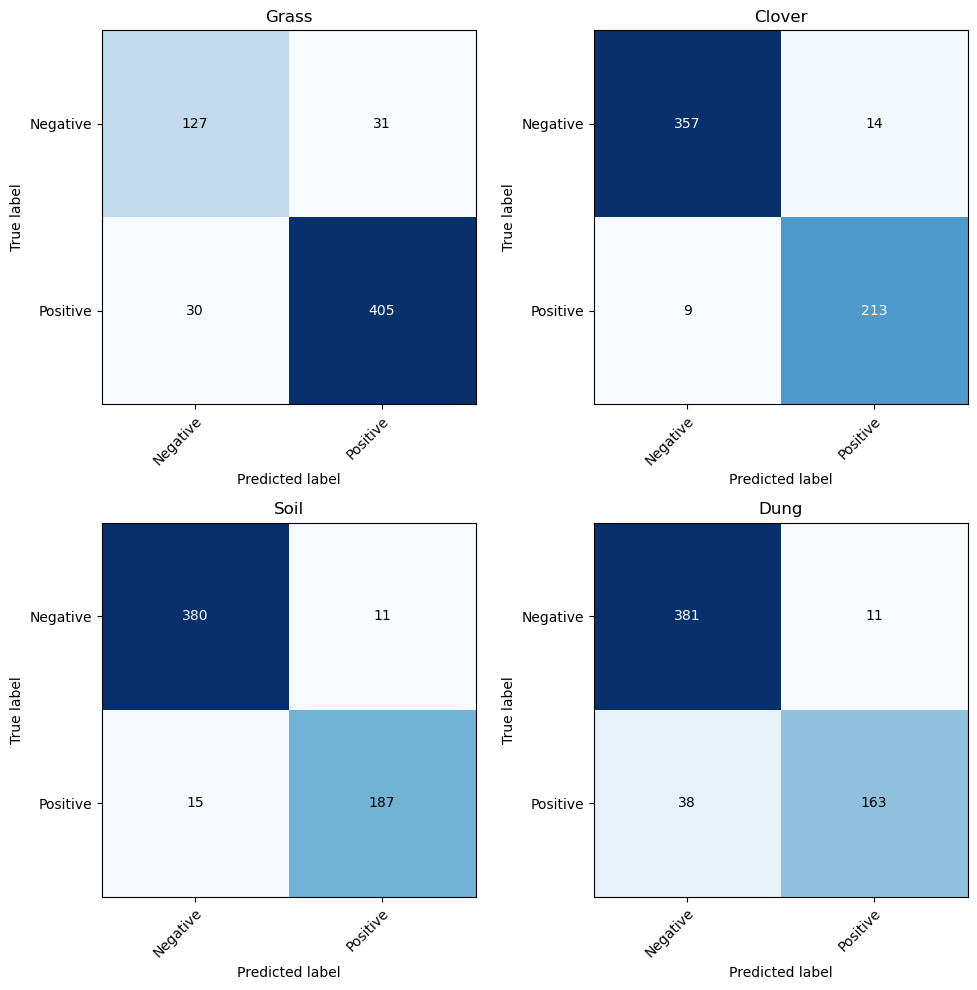

In [42]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, multilabel_confusion_matrix
import keras

class_names = [label for label in label_map.keys()]

sklearn_accuracy = accuracy_score(true_labels, PlantNet_Predictions)

keras_bin_acc = keras.metrics.BinaryAccuracy()
keras_bin_acc.update_state(true_labels, PlantNet_Predictions)
keras_acc = keras_bin_acc.result()
keras_bin_acc.reset_state()

confusion_matrices = multilabel_confusion_matrix(true_labels, PlantNet_Predictions)

num_classes = len(class_names)
grid_size = int(np.ceil(np.sqrt(num_classes)))

fig, axes = plt.subplots(nrows=grid_size, ncols=grid_size, figsize=(10, 10))

# Flatten axes for easy iteration
axes = axes.flatten()

# Plot each confusion matrix
for i, (confusion_matrix, class_name) in enumerate(zip(confusion_matrices, class_names)):
    ax = axes[i]
    im = ax.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    ax.set_title(class_name)

    # Show all ticks and label them with the respective list entries
    ax.set(xticks=np.arange(confusion_matrix.shape[1]),
           yticks=np.arange(confusion_matrix.shape[0]),
           xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'],
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = 'd'
    thresh = confusion_matrix.max() / 2.
    for j in range(confusion_matrix.shape[0]):
        for k in range(confusion_matrix.shape[1]):
            ax.text(k, j, format(confusion_matrix[j, k], fmt),
                    ha="center", va="center",
                    color="white" if confusion_matrix[j, k] > thresh else "black")

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
print(f"Exact match (sklearn) accuracy: {sklearn_accuracy}")
print(f"Keras BinaryAccuracy:           {keras_acc}")
plt.show()


Exact match (sklearn) accuracy: 0.7807757166947723
Keras BinaryAccuracy:           0.9329679608345032


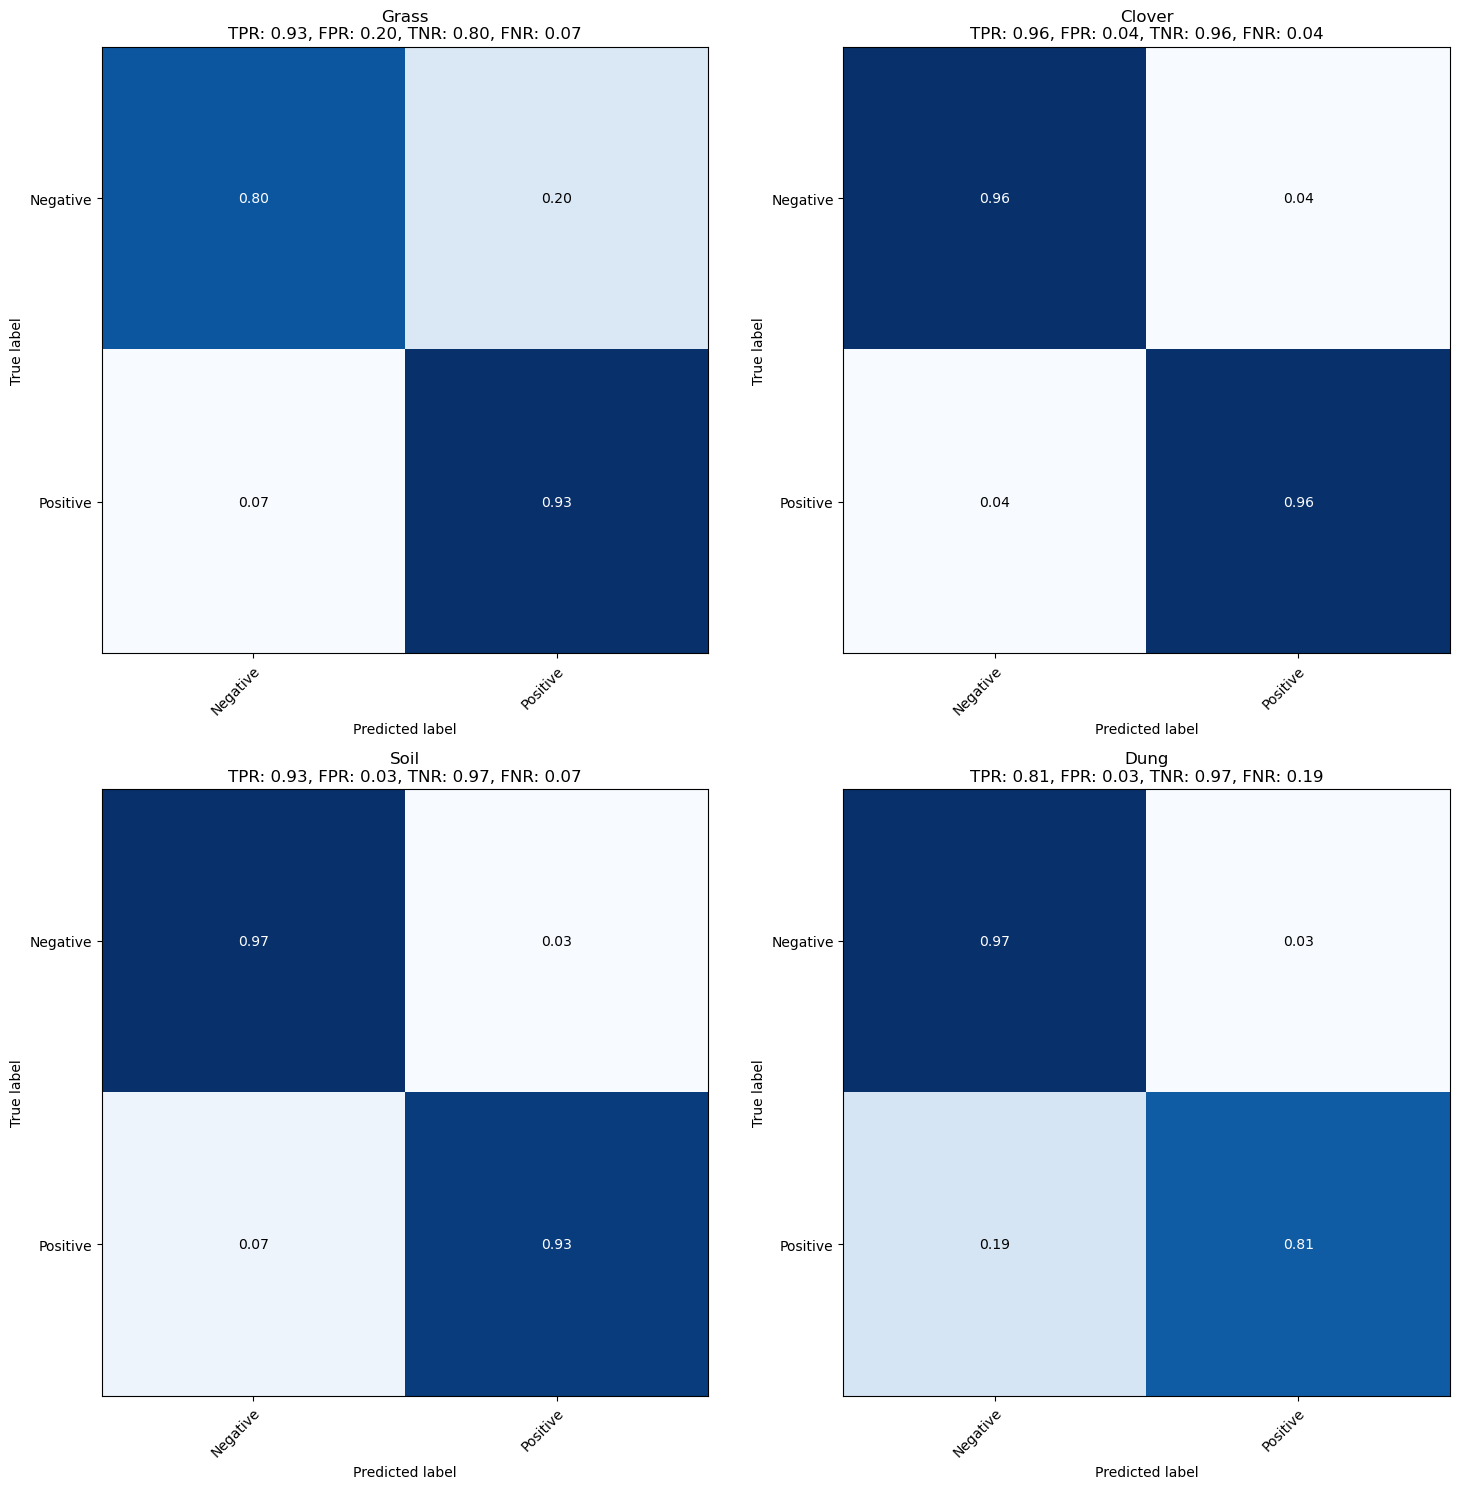

In [54]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, multilabel_confusion_matrix
import keras

class_names = [label for label in label_map.keys()]

sklearn_accuracy = accuracy_score(true_labels, PlantNet_Predictions)

keras_bin_acc = keras.metrics.BinaryAccuracy()
keras_bin_acc.update_state(true_labels, PlantNet_Predictions)
keras_acc = keras_bin_acc.result()
keras_bin_acc.reset_state()

confusion_matrices = multilabel_confusion_matrix(true_labels, PlantNet_Predictions)

num_classes = len(class_names)
grid_size = int(np.ceil(np.sqrt(num_classes)))

fig, axes = plt.subplots(nrows=grid_size, ncols=grid_size, figsize=(15, 15))

# Flatten axes for easy iteration
axes = axes.flatten()

# Plot each confusion matrix
for i, (confusion_matrix, class_name) in enumerate(zip(confusion_matrices, class_names)):
    ax = axes[i]
    
    # Normalize the confusion matrix
    cm_normalized = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]

    # Calculate rates
    TP = confusion_matrix[1, 1]
    TN = confusion_matrix[0, 0]
    FP = confusion_matrix[0, 1]
    FN = confusion_matrix[1, 0]
    TPR = TP / (TP + FN) if (TP + FN) != 0 else 0  # True Positive Rate
    FPR = FP / (FP + TN) if (FP + TN) != 0 else 0  # False Positive Rate
    TNR = TN / (TN + FP) if (TN + FP) != 0 else 0  # True Negative Rate
    FNR = FN / (FN + TP) if (FN + TP) != 0 else 0  # False Negative Rate
    
    im = ax.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
    ax.set_title(f"{class_name}\nTPR: {TPR:.2f}, FPR: {FPR:.2f}, TNR: {TNR:.2f}, FNR: {FNR:.2f}")

    # Show all ticks and label them with the respective list entries
    ax.set(xticks=np.arange(confusion_matrix.shape[1]),
           yticks=np.arange(confusion_matrix.shape[0]),
           xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'],
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f'
    thresh = cm_normalized.max() / 2.
    for j in range(cm_normalized.shape[0]):
        for k in range(cm_normalized.shape[1]):
            ax.text(k, j, format(cm_normalized[j, k], fmt),
                    ha="center", va="center",
                    color="white" if cm_normalized[j, k] > thresh else "black")

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
print(f"Exact match (sklearn) accuracy: {sklearn_accuracy}")
print(f"Keras BinaryAccuracy:           {keras_acc}")
plt.show()


In [ ]:
#@title Baseline PlantNet

In [30]:
PlantNet_model = MultiLabelResNet(PlantNet_model, new_num_classes)

In [27]:
# Evaulate model on test set (inference)

from tqdm import tqdm
import numpy as np

# Detect if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
PlantNet_model.to(device)

PlantNet_model.eval()

PlantNet_Predictions = []

with torch.no_grad():
  for data in tqdm(val_dataset):
      inputs, labels = data
      inputs = inputs.unsqueeze(0).to(device)   # Add batch dimension and move to device

      output = PlantNet_model(inputs)
      predictions = (output > 0.5).float()      # Threshold value of 0.5

      PlantNet_Predictions.append(predictions.cpu().detach().numpy())

PlantNet_Predictions = np.squeeze(np.array(PlantNet_Predictions), axis=1)

100%|██████████| 593/593 [00:25<00:00, 23.71it/s]


Exact match (sklearn) accuracy: 0.006745362563237774
Keras BinaryAccuracy:           0.4751264750957489


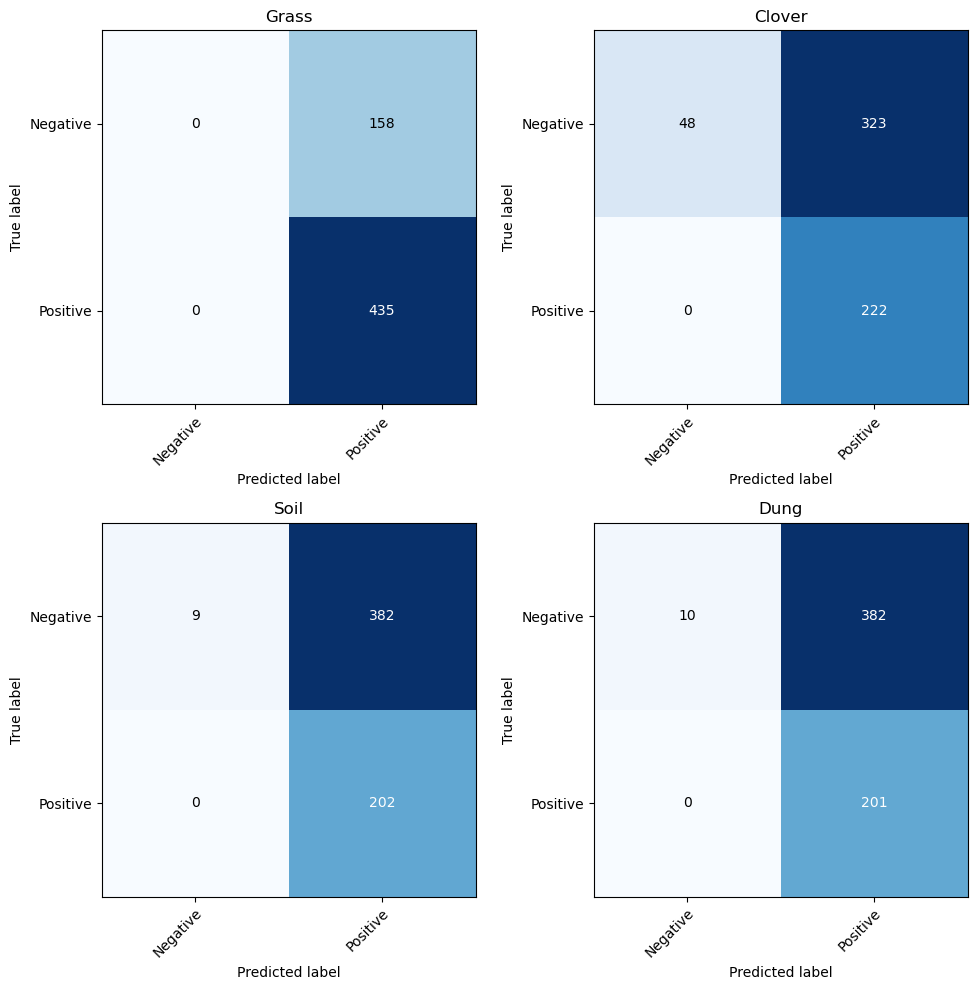

In [28]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, multilabel_confusion_matrix
import keras

class_names = [label for label in label_map.keys()]

sklearn_accuracy = accuracy_score(true_labels, PlantNet_Predictions)

keras_bin_acc = keras.metrics.BinaryAccuracy()
keras_bin_acc.update_state(true_labels, PlantNet_Predictions)
keras_acc = keras_bin_acc.result()
keras_bin_acc.reset_state()

confusion_matrices = multilabel_confusion_matrix(true_labels, PlantNet_Predictions)

num_classes = len(class_names)
grid_size = int(np.ceil(np.sqrt(num_classes)))

fig, axes = plt.subplots(nrows=grid_size, ncols=grid_size, figsize=(10, 10))

# Flatten axes for easy iteration
axes = axes.flatten()

# Plot each confusion matrix
for i, (confusion_matrix, class_name) in enumerate(zip(confusion_matrices, class_names)):
    ax = axes[i]
    im = ax.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    ax.set_title(class_name)

    # Show all ticks and label them with the respective list entries
    ax.set(xticks=np.arange(confusion_matrix.shape[1]),
           yticks=np.arange(confusion_matrix.shape[0]),
           xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'],
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = 'd'
    thresh = confusion_matrix.max() / 2.
    for j in range(confusion_matrix.shape[0]):
        for k in range(confusion_matrix.shape[1]):
            ax.text(k, j, format(confusion_matrix[j, k], fmt),
                    ha="center", va="center",
                    color="white" if confusion_matrix[j, k] > thresh else "black")

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
print(f"Exact match (sklearn) accuracy: {sklearn_accuracy}")
print(f"Keras BinaryAccuracy:           {keras_acc}")
plt.show()


In [31]:
import torch
import keras
import torch.nn as nn
import torch.optim as optim
import time
from tqdm import tqdm

# Fine-tuning function
def fine_tune(model, train_loader, val_loader, optimiser, loss_function, num_epochs=10):

    ''' Inspired by https://keras.io/guides/writing_a_custom_training_loop_in_torch/ '''

    start = time.time()

    # Use keras function for computing accuracy
    # NB labels are one-hot encoded
    # NBB BinaryAccuracy rather than Categorical (less harsh)
    val_acc_metric = keras.metrics.BinaryAccuracy()

    # lists to store loss/accuracy tuples of each epoch
    epoch_val_stats = []

    for epoch in range(num_epochs):

        print(f"epoch {epoch}")

        # Run a validation loop at the end of each epoch
        model.eval()
        val_running_loss = 0.0
        val_num_batches = 0

        with torch.no_grad():
            for x_batch_val, y_batch_val in tqdm(val_loader):
                x_batch_val = x_batch_val.to(device)
                y_batch_val = y_batch_val.to(device)

                # Forward pass
                val_logits = model(x_batch_val)
                val_loss = loss_function(val_logits, y_batch_val)

                # Update validation metrics
                val_acc_metric.update_state(y_batch_val.cpu().detach().numpy(), val_logits.cpu().detach().numpy())

                # Increment validation loss & batch count
                val_running_loss += val_loss.item()
                val_num_batches += 1

        # Get val loss & accuracy for the epoch
        val_epoch_loss = val_running_loss / val_num_batches
        val_epoch_acc = val_acc_metric.result()
        epoch_val_stats.append((val_epoch_loss, val_epoch_acc))

        # Reset metrics at the end of each epoch
        val_acc_metric.reset_state()

        print(f'Epoch [{epoch + 1}/{num_epochs}],Val loss: {val_epoch_loss:.2f}, Val accuracy: {val_epoch_acc:.2f}')


    elapsed_time = time.time() - start
    print('Fine-tuning complete in {:.0f}m {:.0f}s'.format(elapsed_time // 60, elapsed_time % 60))

    return model, epoch_val_stats

In [32]:
# Define loss function and optimiser
loss_function = nn.BCELoss()  # Binary cross-entropy loss for one-hot labels
PlantNet_optimiser = optim.Adam(PlantNet_model.parameters(), lr=0.001)  # Adjust learning rate as needed

# Detect if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
PlantNet_model.to(device)

# Fine-tune the model
PlantNet_model, PlantNet_val_stats = fine_tune(PlantNet_model, train_loader, val_loader, PlantNet_optimiser, loss_function, num_epochs=10)

# Save the model
torch.save(PlantNet_model.state_dict(), '240726_multiclass_plantnet1.pth')

epoch 0


100%|██████████| 19/19 [00:06<00:00,  3.02it/s]


Epoch [1/10],Val loss: 0.72, Val accuracy: 0.45
epoch 1


100%|██████████| 19/19 [00:06<00:00,  3.02it/s]


Epoch [2/10],Val loss: 0.72, Val accuracy: 0.45
epoch 2


 37%|███▋      | 7/19 [00:02<00:04,  2.84it/s]


KeyboardInterrupt: 

Finetune iNaturalist

In [80]:
# First go to this dropbox (https://cornell.app.box.com/s/bnyhq5lwobu6fgjrub44zle0pyjijbmw) and generate download popup to get link to wget weights
!wget "https://public.boxcloud.com/d/1/b1!SBbHNYaY42BM1H9MpqcFtGNo4rjWlvoiMsmqgQvh1MYtsDXhgSSJhosnyMFhCHyTmQXolu5iddTERNM1mphqp6av-0NZBVscUmqx5jMoP2ndSR5Q0mzpDD9qESekATdIvhAwTQP93KiF4iqySZJGUdeZXQOQXNqUOmUxpF4xas2FLLTTlUeNfuKmI0izsvV6gZqo9fecDABcqOOr2X-YjdT2xexa3MMDlW_HQl0zwaR1ORMFKLaoGOgVMj_D9bZkVeqlAAzETRHeTpcwQkq17kaAn7MBKKA1z-pKJ2NTZ8uNCFez-qS58dVeIMct9oM3jQKheN5RRn1YBD64zP38X1IVX6CzSD0F_omRBqikO4a6FPUeWvaqIth1XNY2UUFs6lWLaxxy3SBnwUJ2PqEtvKQkPbimeU2VTHsqBXG800Q4XsI4Nz0ullXdfzwjM2b9lD7feBQ_ss5zHwk7kehLJUVK2RshFY4yRdHf8J0jnQRyQWmis2_yKQBfHY4MHB3DaMulnB1a4zjSTMvdpSa-HyhJs6cC_UdfRvTCbG8MXYH5qKVktKsLc_AHSC6XGFs44OnG7UZ_M72LPi09ScXec1K2q5h0zxUKjV_oUQWF-2tK_N42tqr_sU_yD6Kem6yXr4vuBjyh7goVYayxMAZyeaNQWKLCZKcVibiE82XSittTTqjQgzSXQz9Y9DwKLASJLrAt8XOqFXQ-PJ816k4-ahC996Ey5PTHBZf-Y3hWkTUnOlGMONFgfpvUF0vsZR9tO3nHo-srkt1WNloxymwHxus0NP8a9loBRallPgrmU0l8IWqb_Leb35neVA2jH-u9SgAU6EjZd-6gZCTLcW6-GeofgHrAV5Dh2_7dD0S_eYFpwc04PO7Fldzn4FKfxMpNT99gOr_9b3S_EI-zDTIrzifYkLk-SqNAVfG0mCp70UWymcQOjMpQJDsLnpOW-EFantRqnFCGfwbH2sJ50axWEd9Cj0L6GPe6onjsO0IaOvOzR5AY4Z5lRS6j_ChacCQuFHaNst9MusUNb76x7F59z9nqukJhhQfaP53XMoD5eAJfxBYZkg7ksvnJqUYhCkRU5nTkT6IaHdfn29q6y6VKkwFCvuHg_yIcChhaJXawsp6tqWQWNy6qMTSNcMMqU88bihV42wzC_0tjG3ZsBExMaFFn48X-jArL_ee09uEPI5Piut7jlLFyAc46MbPI6bapFsimjrblyT0L88gDvTJ1n4_1DQxMBM-bzQqX4EbD4LCNegfYTlemnZEwxKQiZi74JOZ_J2cny8ZBdkQTeEEHuDpE5-Yk6A../download" -O cvpr21_newt_pretrained_models.tar.gz

# Unzip models
!tar -xzf cvpr21_newt_pretrained_models.tar.gz

--2024-07-27 02:44:13--  https://public.boxcloud.com/d/1/b1!SBbHNYaY42BM1H9MpqcFtGNo4rjWlvoiMsmqgQvh1MYtsDXhgSSJhosnyMFhCHyTmQXolu5iddTERNM1mphqp6av-0NZBVscUmqx5jMoP2ndSR5Q0mzpDD9qESekATdIvhAwTQP93KiF4iqySZJGUdeZXQOQXNqUOmUxpF4xas2FLLTTlUeNfuKmI0izsvV6gZqo9fecDABcqOOr2X-YjdT2xexa3MMDlW_HQl0zwaR1ORMFKLaoGOgVMj_D9bZkVeqlAAzETRHeTpcwQkq17kaAn7MBKKA1z-pKJ2NTZ8uNCFez-qS58dVeIMct9oM3jQKheN5RRn1YBD64zP38X1IVX6CzSD0F_omRBqikO4a6FPUeWvaqIth1XNY2UUFs6lWLaxxy3SBnwUJ2PqEtvKQkPbimeU2VTHsqBXG800Q4XsI4Nz0ullXdfzwjM2b9lD7feBQ_ss5zHwk7kehLJUVK2RshFY4yRdHf8J0jnQRyQWmis2_yKQBfHY4MHB3DaMulnB1a4zjSTMvdpSa-HyhJs6cC_UdfRvTCbG8MXYH5qKVktKsLc_AHSC6XGFs44OnG7UZ_M72LPi09ScXec1K2q5h0zxUKjV_oUQWF-2tK_N42tqr_sU_yD6Kem6yXr4vuBjyh7goVYayxMAZyeaNQWKLCZKcVibiE82XSittTTqjQgzSXQz9Y9DwKLASJLrAt8XOqFXQ-PJ816k4-ahC996Ey5PTHBZf-Y3hWkTUnOlGMONFgfpvUF0vsZR9tO3nHo-srkt1WNloxymwHxus0NP8a9loBRallPgrmU0l8IWqb_Leb35neVA2jH-u9SgAU6EjZd-6gZCTLcW6-GeofgHrAV5Dh2_7dD0S_eYFpwc04PO7Fldzn4FKfxMpNT99gOr_9b3S_EI-zDTIrzifYkLk-SqNAVfG0mCp70UWy

In [81]:
# Load iNaturalist model and modify the output layer for multilabel classification

import torch
from torchvision.models import resnet50

def load_iNaturalist_model():

  model = resnet50()
  num_iNaturalist_classes = 10000 # 10,000 classes including all species
  model.fc = torch.nn.Linear(in_features=2048, out_features=num_iNaturalist_classes)

  weights_file_path = "cvpr21_newt_pretrained_models/pt/inat2021_supervised_large.pth.tar"
  checkpoint = torch.load(weights_file_path, map_location=torch.device('cpu'))
  model.load_state_dict(checkpoint['state_dict'])

  return model

iNaturalist_model = load_iNaturalist_model()
iNaturalist_model = MultiLabelResNet(iNaturalist_model, new_num_classes)

/tmp/ipykernel_3626201/1801925628.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(weights_file_path, map_location=torch.device('cpu'))


In [82]:
# freeze all weights
freeze_weights(iNaturalist_model)

# unfreeze final layers for finetuning
unfreeze_after_layer4(iNaturalist_model)

In [83]:
# Finetune iNaturalist

# Define loss function and optimiser
loss_function = nn.BCELoss()  # Binary cross-entropy loss for one-hot labels
iNaturalist_optimiser = optim.Adam(iNaturalist_model.parameters(), lr=0.001)  # Adjust learning rate as needed

iNaturalist_model.to(device) # Detect if GPU is available

# Fine-tune the model
iNaturalist_model, iNaturalist_train_stats, iNtauralist_val_stats = fine_tune(iNaturalist_model, train_loader, val_loader, iNaturalist_optimiser, loss_function, num_epochs=10)

# Save the model
torch.save(iNaturalist_model.state_dict(), '/content/drive/MyDrive/team_challenge/240726_multiclass_iNaturalist.pth')

100%|██████████| 19/19 [00:05<00:00,  3.80it/s]


Initial Train loss: 0.80, Train accuracy: 0.48, Val loss: 0.80, Val accuracy: 0.48
epoch 0


100%|██████████| 19/19 [00:05<00:00,  3.68it/s]


Epoch [1/10], Train loss: 0.25, Train accuracy: 0.90, Val loss: 0.20, Val accuracy: 0.93
epoch 1


100%|██████████| 19/19 [00:04<00:00,  3.81it/s]


Epoch [2/10], Train loss: 0.14, Train accuracy: 0.95, Val loss: 0.18, Val accuracy: 0.93
epoch 2


100%|██████████| 19/19 [00:05<00:00,  3.47it/s]


Epoch [3/10], Train loss: 0.11, Train accuracy: 0.96, Val loss: 0.28, Val accuracy: 0.93
epoch 3


100%|██████████| 19/19 [00:04<00:00,  3.83it/s]


Epoch [4/10], Train loss: 0.09, Train accuracy: 0.97, Val loss: 0.28, Val accuracy: 0.92
epoch 4


100%|██████████| 19/19 [00:05<00:00,  3.75it/s]


Epoch [5/10], Train loss: 0.05, Train accuracy: 0.98, Val loss: 0.21, Val accuracy: 0.93
epoch 5


100%|██████████| 19/19 [00:05<00:00,  3.70it/s]


Epoch [6/10], Train loss: 0.05, Train accuracy: 0.98, Val loss: 0.35, Val accuracy: 0.94
epoch 6


100%|██████████| 19/19 [00:05<00:00,  3.77it/s]


Epoch [7/10], Train loss: 0.04, Train accuracy: 0.99, Val loss: 0.27, Val accuracy: 0.93
epoch 7


100%|██████████| 19/19 [00:05<00:00,  3.67it/s]


Epoch [8/10], Train loss: 0.03, Train accuracy: 0.99, Val loss: 0.29, Val accuracy: 0.94
epoch 8


100%|██████████| 19/19 [00:05<00:00,  3.78it/s]


Epoch [9/10], Train loss: 0.03, Train accuracy: 0.99, Val loss: 0.28, Val accuracy: 0.94
epoch 9


100%|██████████| 19/19 [00:05<00:00,  3.78it/s]


Epoch [10/10], Train loss: 0.03, Train accuracy: 0.99, Val loss: 0.32, Val accuracy: 0.94
Fine-tuning complete in 5m 44s


RuntimeError: Parent directory /content/drive/MyDrive/team_challenge does not exist.

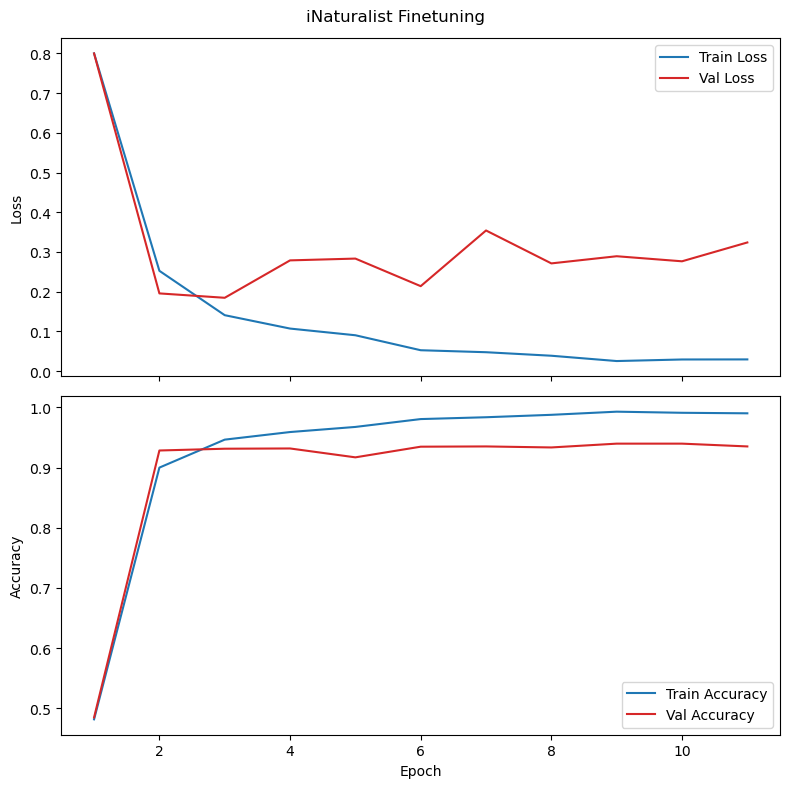

In [84]:
plot_training_history(iNaturalist_train_stats, iNtauralist_val_stats, "iNaturalist Finetuning")

In [86]:
# Evaulate model on test set (inference)

from tqdm import tqdm
import numpy as np

# Detect if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
iNaturalist_model.to(device)

iNaturalist_model.eval()

iNaturalist_predictions = []

with torch.no_grad():
  for data in tqdm(val_dataset):
      inputs, labels = data
      inputs = inputs.unsqueeze(0).to(device)   # Add batch dimension and move to device

      output = iNaturalist_model(inputs)
      predictions = (output > 0.5).float()      # Threshold value of 0.5

      iNaturalist_predictions.append(predictions.cpu().detach().numpy())

iNaturalist_predictions = np.squeeze(np.array(iNaturalist_predictions), axis=1)

100%|██████████| 593/593 [00:24<00:00, 24.01it/s]


Exact match (sklearn) accuracy: 0.7925801011804384
Keras BinaryAccuracy:           0.9350758790969849


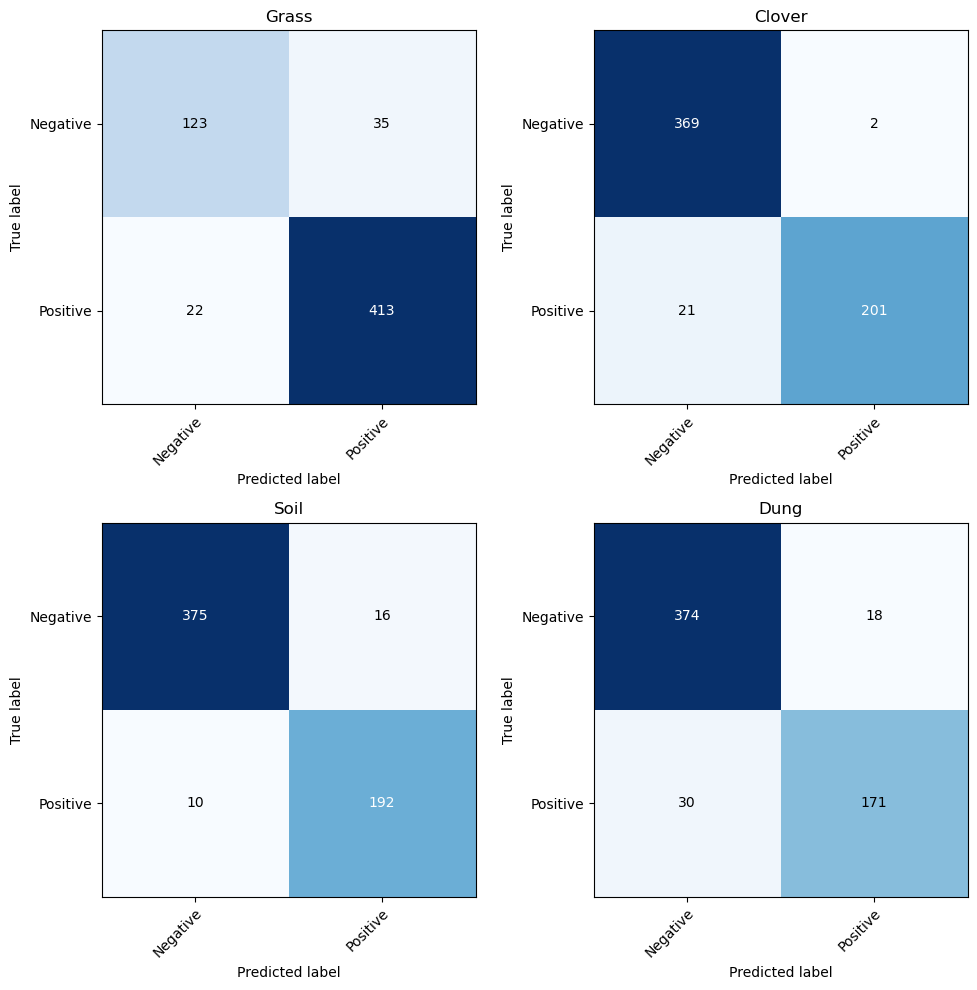

In [88]:

sklearn_accuracy = accuracy_score(true_labels, iNaturalist_predictions)

keras_bin_acc = keras.metrics.BinaryAccuracy()
keras_bin_acc.update_state(true_labels, iNaturalist_predictions)
keras_acc = keras_bin_acc.result()
keras_bin_acc.reset_state()

confusion_matrices = multilabel_confusion_matrix(true_labels, iNaturalist_predictions)

num_classes = len(class_names)
grid_size = int(np.ceil(np.sqrt(num_classes)))

fig, axes = plt.subplots(nrows=grid_size, ncols=grid_size, figsize=(10, 10))

# Flatten axes for easy iteration
axes = axes.flatten()

# Plot each confusion matrix
for i, (confusion_matrix, class_name) in enumerate(zip(confusion_matrices, class_names)):
    ax = axes[i]
    im = ax.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    ax.set_title(class_name)

    # Show all ticks and label them with the respective list entries
    ax.set(xticks=np.arange(confusion_matrix.shape[1]),
           yticks=np.arange(confusion_matrix.shape[0]),
           xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'],
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = 'd'
    thresh = confusion_matrix.max() / 2.
    for j in range(confusion_matrix.shape[0]):
        for k in range(confusion_matrix.shape[1]):
            ax.text(k, j, format(confusion_matrix[j, k], fmt),
                    ha="center", va="center",
                    color="white" if confusion_matrix[j, k] > thresh else "black")

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
print(f"Exact match (sklearn) accuracy: {sklearn_accuracy}")
print(f"Keras BinaryAccuracy:           {keras_acc}")
plt.show()


Exact match (sklearn) accuracy: 0.7925801011804384
Keras BinaryAccuracy:           0.9350758790969849


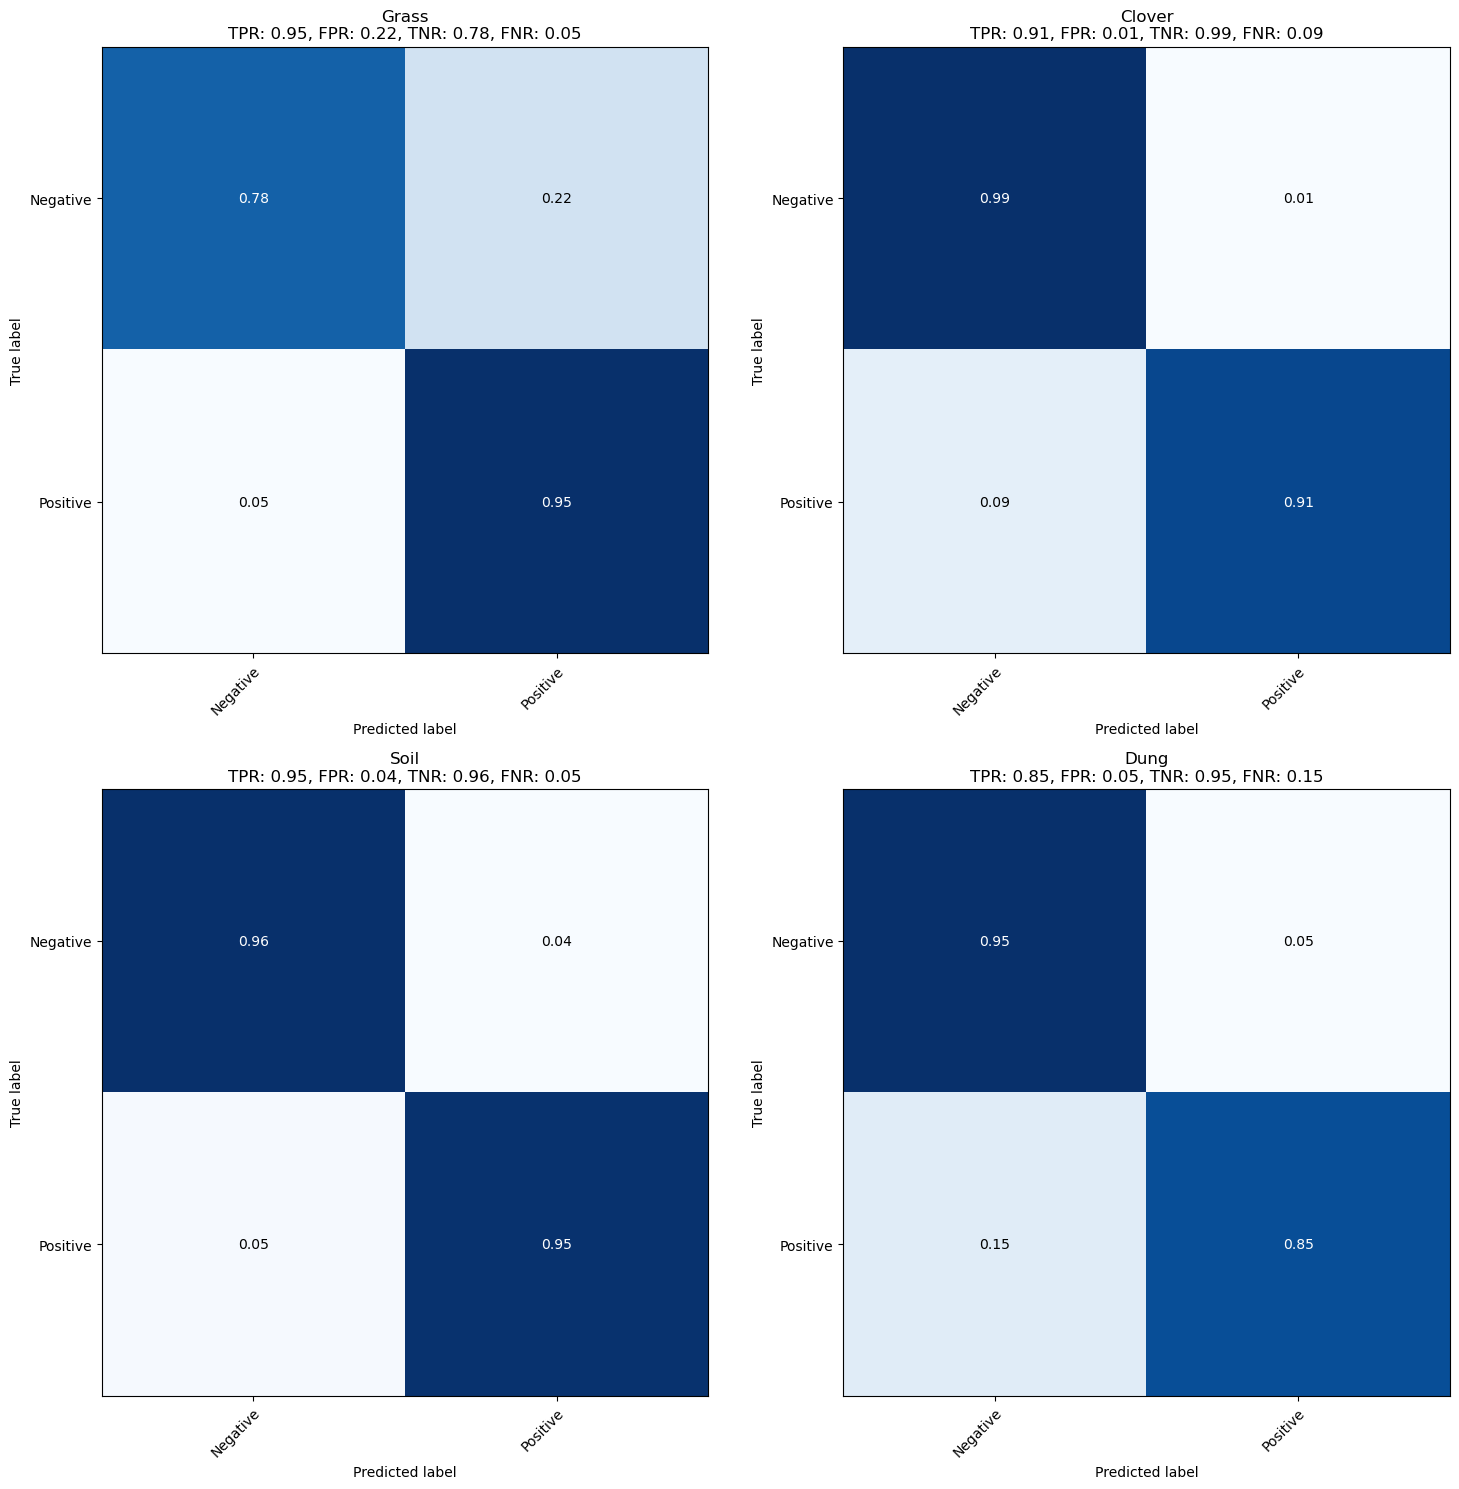

In [90]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, multilabel_confusion_matrix
import keras

class_names = [label for label in label_map.keys()]

sklearn_accuracy = accuracy_score(true_labels, iNaturalist_predictions)

keras_bin_acc = keras.metrics.BinaryAccuracy()
keras_bin_acc.update_state(true_labels, iNaturalist_predictions)
keras_acc = keras_bin_acc.result()
keras_bin_acc.reset_state()

confusion_matrices = multilabel_confusion_matrix(true_labels, iNaturalist_predictions)

num_classes = len(class_names)
grid_size = int(np.ceil(np.sqrt(num_classes)))

fig, axes = plt.subplots(nrows=grid_size, ncols=grid_size, figsize=(15, 15))

# Flatten axes for easy iteration
axes = axes.flatten()

# Plot each confusion matrix
for i, (confusion_matrix, class_name) in enumerate(zip(confusion_matrices, class_names)):
    ax = axes[i]
    
    # Normalize the confusion matrix
    cm_normalized = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]

    # Calculate rates
    TP = confusion_matrix[1, 1]
    TN = confusion_matrix[0, 0]
    FP = confusion_matrix[0, 1]
    FN = confusion_matrix[1, 0]
    TPR = TP / (TP + FN) if (TP + FN) != 0 else 0  # True Positive Rate
    FPR = FP / (FP + TN) if (FP + TN) != 0 else 0  # False Positive Rate
    TNR = TN / (TN + FP) if (TN + FP) != 0 else 0  # True Negative Rate
    FNR = FN / (FN + TP) if (FN + TP) != 0 else 0  # False Negative Rate
    
    im = ax.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
    ax.set_title(f"{class_name}\nTPR: {TPR:.2f}, FPR: {FPR:.2f}, TNR: {TNR:.2f}, FNR: {FNR:.2f}")

    # Show all ticks and label them with the respective list entries
    ax.set(xticks=np.arange(confusion_matrix.shape[1]),
           yticks=np.arange(confusion_matrix.shape[0]),
           xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'],
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f'
    thresh = cm_normalized.max() / 2.
    for j in range(cm_normalized.shape[0]):
        for k in range(cm_normalized.shape[1]):
            ax.text(k, j, format(cm_normalized[j, k], fmt),
                    ha="center", va="center",
                    color="white" if cm_normalized[j, k] > thresh else "black")

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
print(f"Exact match (sklearn) accuracy: {sklearn_accuracy}")
print(f"Keras BinaryAccuracy:           {keras_acc}")
plt.show()


In [ ]:
TUNE LR